Implémentation du papier de recherche "Model-based clustering based on sparse finite Gaussian mixtures" Gertraud Malsiner-Walli · Sylvia Frühwirth-Schnatter · Bettina Grün

In [19]:
import numpy as np
from scipy.stats import dirichlet, wishart, multivariate_normal, geninvgauss, mode
from scipy.cluster.vq import kmeans2
from scipy.special import gammaln
from itertools import permutations

In [20]:
class SparseGaussianMixture:
    def __init__(self, K, e0, c0, nu1, nu2, sample_e0=False):
        self.K = K
        self.e0 = e0
        self.c0 = c0
        self.nu1 = nu1
        self.nu2 = nu2
        self.sample_e0 = sample_e0  # Si True, on échantillonne e0 avec MH
    
    def fit(self, y, max_iter=10000, burn_in=1000):
        """On entraine le Sparse Gaussian Mixture Model"""

        N, r = y.shape
        self.N = N
        self.r = r

        # hyperparamètres
        R = np.ptp(y, axis=0) # Définis la plage des données
        R = np.maximum(R, 1e-6)
        self.R = R
        R0 = np.diag(R**2)
        g0 = 0.5 + (r - 1) / 2
        G0 = (100 * g0 / self.c0) * np.diag(1 / R**2) #hyperparamètre de C0 avec wishart
        m0 = np.median(y, axis=0)

        # Pour MH de e0
        e0_current = self.e0
        # Paramètres du Prior Gamma pour e0 
        a_prior = 10.0
        b_prior = a_prior * self.K

        # C0 est initialisé à G0 (mais variera ensuite)
        C0 = G0.copy()

        # initialisation avec kmeans
        centroids, labels = kmeans2(y, self.K, minit='points')
        S = labels

        self.eta = np.ones(self.K) / self.K #On intialise les poids des clusters de manière uniforme
        mu = centroids # On initialise les moyennes des clusters avec les centroïdes de kmeans
        Sigma_inv = np.array([np.eye(r) for _ in range(self.K)]) # On initialise les matrices de précision comme des matrices identité
        lamb = np.ones(r) # On initialise les paramètres de sparsité à 1
        b0 = m0
        
        # Pour MH de e0
        e0_current = self.e0

        Nk = np.zeros(self.K)
        y_bar = np.zeros((self.K, r))
        
        # On initialise les traces pour les futures graphiques
        self.trace_mu = []
        self.list_S_counts = []
        self.trace_eta = []
        self.trace_Nk = []
        self.trace_lambda = []  # Pour Figure 8 du papier
        self.trace_sigma = []
        self.trace_e0 = []  # Pour suivre e0 si échantillonné
        self.trace_S = []  # Pour calculer MCR
        self.all_trace_Nk = []  # Trace complète (incluant burn-in) pour Figure 6/7

        #On démarre la boucle de Gibbs sampling de l'appendix 1
        for i in range(max_iter):
            
            # On met à jour les Nk, le nombre de points dans chaque cluster, et y_bar, la moyenne des points dans chaque cluster
            for k in range(self.K):
                Nk[k] = np.sum(S == k)
                if Nk[k] > 0:
                    y_bar[k] = np.mean(y[S == k], axis=0)
            
            #1a) On définit les ek, paramètres de la loi de Dirichlet
            ek = e0_current + Nk
            self.eta = dirichlet.rvs(ek)[0] # On échantillonne les poids des clusters à partir de la loi de Dirichlet

            #1b) On échantillonne les matrices de précision des clusters
            Sigma = []
            for k in range(self.K):
                nk = Nk[k]
                ck = self.c0 + nk/2
                
                #On distingue 2 cas selon que le cluster k contient des points ou non
                if Nk[k] > 0:
                    diff = y[(S == k)] - mu[k]
                    sum = diff.T @ diff
                else:
                    sum = np.zeros((r, r))

                # on update les paramètres de wishart
                ck = self.c0 + Nk[k] / 2
                Ck = C0 + sum /2

                #On ajoute une petite régularisation pour que la matrice soit définie positive
                Ck += 1e-6 * np.eye(r)
                Ck = (Ck + Ck.T) / 2

                # Sampling. Scipy prend scale matrix, donc inv(Ck)
                scale_mat = np.linalg.inv(Ck)
                scale_mat = (scale_mat + scale_mat.T) / 2
                Sigma_k_inv = wishart.rvs(df=ck, scale=scale_mat)
                
                # Assurer que Sigma_k_inv est symétrique
                Sigma_k_inv = (Sigma_k_inv + Sigma_k_inv.T) / 2
                Sigma_inv[k] = Sigma_k_inv
                
                # Inverser pour obtenir Sigma avec régularisation
                try:
                    Sigma_k = np.linalg.inv(Sigma_k_inv)
                    # Assurer symétrie et définie positive
                    Sigma_k = (Sigma_k + Sigma_k.T) / 2
                    # Régularisation pour garantir définie positive
                    eigvals = np.linalg.eigvalsh(Sigma_k)
                    if np.min(eigvals) < 1e-6:
                        Sigma_k += (1e-6 - np.min(eigvals) + 1e-6) * np.eye(r)
                except np.linalg.LinAlgError:
                    Sigma_k = np.eye(r)
                
                Sigma.append(Sigma_k)

            Sigma = np.array(Sigma)

            #1c) On échantillonne les moyennes des clusters
            B0_inv = np.diag(1 / (R**2 * lamb + 1e-10)) #l'inverse de B0
            for k in range(self.K):
                try:
                    Bk_inv = B0_inv + Nk[k] * Sigma_inv[k]
                    Bk_inv = (Bk_inv + Bk_inv.T) / 2
                    Bk = np.linalg.inv(Bk_inv)
                    Bk = (Bk + Bk.T) / 2
                    
                    # Régularisation pour garantir définie positive
                    eigvals = np.linalg.eigvalsh(Bk)
                    if np.min(eigvals) < 1e-8:
                        Bk += (1e-8 - np.min(eigvals) + 1e-8) * np.eye(r)
                    
                    prior_part = B0_inv @ b0
                    data_part = Sigma_inv[k] @ (Nk[k] * y_bar[k])
                    
                    bk = Bk @ (prior_part + data_part)
                    mu[k] = multivariate_normal.rvs(mean=bk, cov=Bk)
                except (np.linalg.LinAlgError, ValueError):
                    # En cas d'erreur, garder l'ancienne valeur de mu[k]
                    pass

            #2) Classificatipon des observations
            log_probs = np.zeros((N, self.K)) #On passe par le log pour éviter les underflows
            for k in range(self.K):
                try:
                    # Assurer que la covariance est valide
                    cov_k = Sigma[k].copy()
                    cov_k = (cov_k + cov_k.T) / 2
                    eigvals = np.linalg.eigvalsh(cov_k)
                    if np.min(eigvals) < 1e-6:
                        cov_k += (1e-6 - np.min(eigvals) + 1e-6) * np.eye(r)
                    
                    log_pdf = multivariate_normal.logpdf(y, mean=mu[k], cov=cov_k)
                    log_probs[:, k] = np.log(self.eta[k] + 1e-10) + log_pdf
                except (np.linalg.LinAlgError, ValueError):
                    log_probs[:, k] = -np.inf # Composante dégénérée

            max_log = np.max(log_probs, axis=1, keepdims=True)
            probs = np.exp(log_probs - max_log)
            row_sums = np.sum(probs, axis=1, keepdims=True)
            # Gestion des cas où la proba est nulle partout (outliers extrêmes)
            probs = np.divide(probs, row_sums, out=np.ones_like(probs)/self.K, where=row_sums!=0)
            
            S = np.array([np.argmax(np.random.multinomial(1, p)) for p in probs]) #échantillonnage des nouvelles affectations

            #3) On échantillonne les paramètres de sparsité

            #3a) On échantillonne les C0
            # C0 ~ Wishart(g0 + K*c0, (G0 + sum(Sigma_k_inv))^{-1})
            df_C0 = g0 + self.K * self.c0
            sum_Sigma_inv = np.sum(Sigma_inv, axis=0)
            scale_C0_inv = G0 + sum_Sigma_inv
            scale_C0_inv = (scale_C0_inv + scale_C0_inv.T) / 2 + 1e-6 * np.eye(r)
            scale_C0 = np.linalg.inv(scale_C0_inv)
            scale_C0 = (scale_C0 + scale_C0.T) / 2
            C0 = wishart.rvs(df=df_C0, scale=scale_C0)

            #3b) On échantillonne le e0 avec Metropolis-Hastings (si activé)
            if self.sample_e0:
                # Proposal: Random walk on log scale
                log_e0_current = np.log(e0_current)
                log_e0_proposal = log_e0_current + np.random.normal(0, 0.5)
                e0_proposal = np.exp(log_e0_proposal)
                
                # Log-likelihood (Dirichlet)
                # log p(η | e0)
                log_lik_current = (gammaln(self.K * e0_current) - self.K * gammaln(e0_current) 
                                   + (e0_current - 1) * np.sum(np.log(self.eta + 1e-300)))
                log_lik_proposal = (gammaln(self.K * e0_proposal) - self.K * gammaln(e0_proposal) 
                                    + (e0_proposal - 1) * np.sum(np.log(self.eta + 1e-300)))
                
                # CORRECTION ICI: Log-Prior ratio (Gamma distribution) 
                # p(e0) ~ Gamma(a, aK)
                log_prior_curr = (a_prior - 1) * log_e0_current - b_prior * e0_current
                log_prior_prop = (a_prior - 1) * log_e0_proposal - b_prior * e0_proposal
                log_prior_ratio = log_prior_prop - log_prior_curr
                
                # Jacobian for log transform (proposal on log scale)
                log_jacobian = log_e0_proposal - log_e0_current
                
                # Accept/reject
                log_alpha = log_lik_proposal - log_lik_current + log_prior_ratio + log_jacobian
                if np.log(np.random.uniform()) < log_alpha:
                    e0_current = e0_proposal

            #3c) On échantillonne les lambdas
            pK = self.nu1 - self.K / 2
            aj = 2 * self.nu2
            for j in range(r):
                bj = np.sum((mu[:, j] - b0[j])**2) / R[j]**2 
                bj = max(bj, 1e-10) # Pour éviter les divisions par zéro
                b_scipy = np.sqrt(aj * bj)
                scale_scipy = np.sqrt(bj / aj)
                lamb[j] = geninvgauss.rvs(p=pK, b=b_scipy, loc=0, scale=scale_scipy) # On échantillonne lambda_j selon la loi GIG

            # 3d. b0
            cov_b0 = np.diag(R**2 * lamb) / self.K
            mean_b0 = np.mean(mu, axis=0)
            b0 = multivariate_normal.rvs(mean=mean_b0, cov=cov_b0)

            #4) On applique la permutation pour éviter le label switching
            perm = np.random.permutation(self.K)
            mu = mu[perm]
            Sigma = Sigma[perm]
            Sigma_inv = Sigma_inv[perm]
            self.eta = self.eta[perm]

            mapping = np.zeros(self.K, dtype=int)
            mapping[perm] = np.arange(self.K)

            inv_perm = np.argsort(perm)
            S = inv_perm[S]
            
            # Trace complète pour les plots (incluant burn-in)
            current_Nk = np.array([np.sum(S == k) for k in range(self.K)])
            self.all_trace_Nk.append(current_Nk.copy())

            if i >= burn_in:
                # On stocke les résultats après la période de burn-in
                self.trace_mu.append(mu.copy())
                k0_m = self.K - np.sum(current_Nk == 0) 
                self.list_S_counts.append(k0_m)
                self.trace_Nk.append(current_Nk.copy())
                self.trace_eta.append(self.eta.copy())
                self.trace_lambda.append(lamb.copy())
                self.trace_sigma.append(Sigma.copy())
                self.trace_e0.append(e0_current)
                self.trace_S.append(S.copy())
        
        # Stocker e0 final
        self.e0_estimated = np.mean(self.trace_e0) if self.sample_e0 else self.e0
        self._identify_model(r, y)
    
    def _identify_model(self, r, y):
        # Appendix 2
        # 1. Nombre de clusters non vides pour chaque itération
        # K0_m = K - somme(I(Nk=0))
        trace_Nk = np.array(self.trace_Nk)
        K0_list = self.K - np.sum(trace_Nk == 0, axis=1)
        
        # 2. Estimer K_hat (Mode)
        vals, counts = np.unique(K0_list, return_counts=True)
        self.K_hat = vals[np.argmax(counts)]
        print(f"Nombre de clusters estimé (Mode K0): {self.K_hat}")

        # Sous-séquence M0 où le nombre de clusters actifs == K_hat 
        valid_indices = np.where(K0_list == self.K_hat)[0]
        self.M0 = len(valid_indices)
        
        if self.M0 == 0:
            print("Aucune itération avec le mode K0 trouvée.")
            return

        # 3. Collecter les draws des composantes NON VIDES 
        valid_mus = []
        valid_sigmas = []
        
        # On garde une trace de quel itération vient chaque point pour reconstruire ensuite
        # iteration_map[i] = liste des indices dans valid_mus appartenant à l'itération i
        iteration_map = {} 
        counter = 0
        
        for idx in valid_indices:
            # Récupérer les indices des clusters actifs à cette itération
            # trace_Nk[idx] correspond aux effectifs permutés
            active_k = np.where(trace_Nk[idx] > 0)[0]
            
            # Vérification de sécurité (doit être égal à K_hat)
            if len(active_k) != self.K_hat:
                continue 
                
            iteration_indices = []
            for k in active_k:
                valid_mus.append(self.trace_mu[idx][k])
                valid_sigmas.append(self.trace_sigma[idx][k]) 
                iteration_indices.append(counter)
                counter += 1
            
            iteration_map[idx] = iteration_indices

        X_cluster = np.array(valid_mus)

        # 4. Clustering des draws dans l'espace des paramètres
        # Le papier recommande Mahalanobis car les nuages de points de mu sont elliptiques.
        centroids_mu, covs_mu, labels_point_process = self._k_centroids_mahalanobis(X_cluster, self.K_hat)
        
        # 5. Reconstruire les permutations (Relabeling)
        sorted_mus = []
        sorted_etas = []
        sorted_sigmas = []
        valid_perm_count = 0
        
        for idx in valid_indices:
            if idx not in iteration_map: continue
            
            # Les indices dans X_cluster correspondant à cette itération MCMC
            indices_in_X = iteration_map[idx]
            
            # Les labels de cluster (0..K_hat-1) assignés à ces points
            assigned_labels = labels_point_process[indices_in_X]
            
            # Vérifier si c'est une permutation valide de (0..K_hat-1)
            if len(np.unique(assigned_labels)) == self.K_hat:
                valid_perm_count += 1
                # Récupérer les paramètres bruts de l'itération
                raw_mu = self.trace_mu[idx]
                raw_eta = self.trace_eta[idx]
                raw_nk = self.trace_Nk[idx]
                raw_sigma = self.trace_sigma[idx]
                
                # Indices des actifs dans le vecteur brut (taille K=15)
                active_indices_raw = np.where(raw_nk > 0)[0]
                
                # On crée des vecteurs de taille K_hat pour stocker les paramètres re-triés
                mu_aligned = np.zeros((self.K_hat, r))
                eta_aligned = np.zeros(self.K_hat)
                sigma_aligned = np.zeros((self.K_hat, r, r))
                
                # Pour chaque cluster cible c (0..K_hat-1)
                for c in range(self.K_hat):
                    pos_in_active = np.where(assigned_labels == c)[0][0]
                    original_k = active_indices_raw[pos_in_active]
                    
                    mu_aligned[c] = raw_mu[original_k]
                    eta_aligned[c] = raw_eta[original_k]
                    sigma_aligned[c] = raw_sigma[original_k]
                
                sorted_mus.append(mu_aligned)
                sorted_etas.append(eta_aligned)
                sorted_sigmas.append(sigma_aligned)
        
        # M0,p = proportion of valid permutations
        self.M0_p = valid_perm_count / self.M0 if self.M0 > 0 else 0

        # 6. Inférence finale
        if len(sorted_mus) > 0:
            self.final_mu = np.mean(sorted_mus, axis=0)
            self.final_eta = np.mean(sorted_etas, axis=0)
            self.final_eta /= np.sum(self.final_eta)
            self.final_sigma = np.mean(sorted_sigmas, axis=0)
            print("Estimation terminée.")
            print(f"Poids finaux : {self.final_eta}")
            print(f"Centres finaux : \n{self.final_mu}")
        else:
            print("Echec du relabeling.")
            # Fallback: utiliser les derniers mu actifs
            last_Nk = self.trace_Nk[-1]
            last_mu = self.trace_mu[-1]
            last_sigma = self.trace_sigma[-1]
            last_eta = self.trace_eta[-1]
            active_k = np.where(last_Nk > 0)[0]
            self.final_mu = last_mu[active_k]
            self.final_eta = last_eta[active_k]
            self.final_eta /= np.sum(self.final_eta)
            self.final_sigma = last_sigma[active_k]
        
        # Calculer MCR (Misclassification Rate)
        self._compute_mcr(y)

    def _compute_mcr(self, y):
        """Calcule le Misclassification Rate (MCR) comme dans le papier"""
        # Classification basée sur les paramètres finaux
        N = y.shape[0]
        r = y.shape[1]
        log_probs = np.zeros((N, self.K_hat))
        
        for k in range(self.K_hat):
            try:
                # Régulariser la covariance
                cov_k = self.final_sigma[k].copy()
                cov_k = (cov_k + cov_k.T) / 2
                eigvals = np.linalg.eigvalsh(cov_k)
                if np.min(eigvals) < 1e-6:
                    cov_k += (1e-6 - np.min(eigvals) + 1e-6) * np.eye(r)
                
                log_pdf = multivariate_normal.logpdf(y, mean=self.final_mu[k], cov=cov_k)
                log_probs[:, k] = np.log(self.final_eta[k] + 1e-10) + log_pdf
            except:
                log_probs[:, k] = -np.inf
        
        self.predicted_labels = np.argmax(log_probs, axis=1)
    
    def compute_mse(self, true_mu):
        """Calcule MSE_μ comme dans le papier (Table 1-2)"""
        if not hasattr(self, 'final_mu') or self.final_mu is None:
            return np.nan
        
        K_true = len(true_mu)
        K_est = len(self.final_mu)
        
        if K_est != K_true:
            # Si K différent, on ne peut pas calculer directement
            return np.nan
        
        best_mse = np.inf
        for perm in permutations(range(K_est)):
            mse = 0
            for k_true in range(K_true):
                k_est = perm[k_true]
                mse += np.sum((self.final_mu[k_est] - true_mu[k_true])**2)
            mse /= K_true
            best_mse = min(best_mse, mse)
        
        self.mse_mu = best_mse
        return best_mse
    
    def compute_mcr_with_true_labels(self, true_labels):
        """Calcule MCR avec les vrais labels"""
        
        if not hasattr(self, 'predicted_labels'):
            return np.nan
        
        K_est = self.K_hat
        K_true = len(np.unique(true_labels))
        
        if K_est != K_true:
            # Approximation si K différent
            return 1 - np.mean(self.predicted_labels == true_labels)
        
        # Trouver la meilleure permutation
        best_mcr = 1.0
        for perm in permutations(range(K_est)):
            relabeled = np.array([perm[l] for l in self.predicted_labels])
            mcr = np.mean(relabeled != true_labels)
            best_mcr = min(best_mcr, mcr)
        
        self.mcr = best_mcr
        return best_mcr

    def _k_centroids_mahalanobis(self, X, K, max_iter=20):
        # Init centroids (kmeans classique pour demarrer)
        centers, _ = kmeans2(X, K, minit='points')
        # Init covariances (Identite)
        r = X.shape[1]
        covs = np.array([np.eye(r) for _ in range(K)])
        covs_inv = np.array([np.eye(r) for _ in range(K)])
        
        labels = np.zeros(X.shape[0], dtype=int)
        
        for it in range(max_iter):
            # 1. Assignment step avec distance Mahalanobis [cite: 3130]
            # d^2(x, c) = (x-c)^T S^-1 (x-c)
            dists = np.zeros((X.shape[0], K))
            for k in range(K):
                diff = X - centers[k]
                # Calcul vectorisé de la distance de Mahalanobis diag(diff @ S_inv @ diff.T)
                # Optimisation: sum((diff @ S_inv) * diff, axis=1)
                dists[:, k] = np.sum((diff @ covs_inv[k]) * diff, axis=1)
            
            new_labels = np.argmin(dists, axis=1)
            
            if np.array_equal(new_labels, labels):
                break
            labels = new_labels
            
            # 2. Update step 
            for k in range(K):
                mask = (labels == k)
                if np.sum(mask) > 1: # Il faut au moins 2 points pour la covariance
                    cluster_data = X[mask]
                    centers[k] = np.mean(cluster_data, axis=0)
                    # Estimation de la covariance du cluster
                    cov = np.cov(cluster_data, rowvar=False) + 1e-6 * np.eye(r) # Regularisation
                    covs[k] = cov
                    covs_inv[k] = np.linalg.inv(cov)
                
        return centers, covs, labels


    def predict(self, y_new):
        """Classification basée sur le modèle identifié (MAP)"""
        N = y_new.shape[0]
        K = len(self.final_eta)
        log_probs = np.zeros((N, K))
        
        for k in range(K):
            try:
                # Utilise mu ET Sigma identifiés
                log_pdf = multivariate_normal.logpdf(y_new, mean=self.final_mu[k], cov=self.final_sigma[k])
                log_probs[:, k] = np.log(self.final_eta[k] + 1e-10) + log_pdf
            except Exception:
                log_probs[:, k] = -np.inf
        
        return np.argmax(log_probs, axis=1)
            


                
                


TEST 1: Scénario 'equal weights' (Section 5.1.1)
Prior: Normal-Gamma (Ng) avec échantillonnage de e0


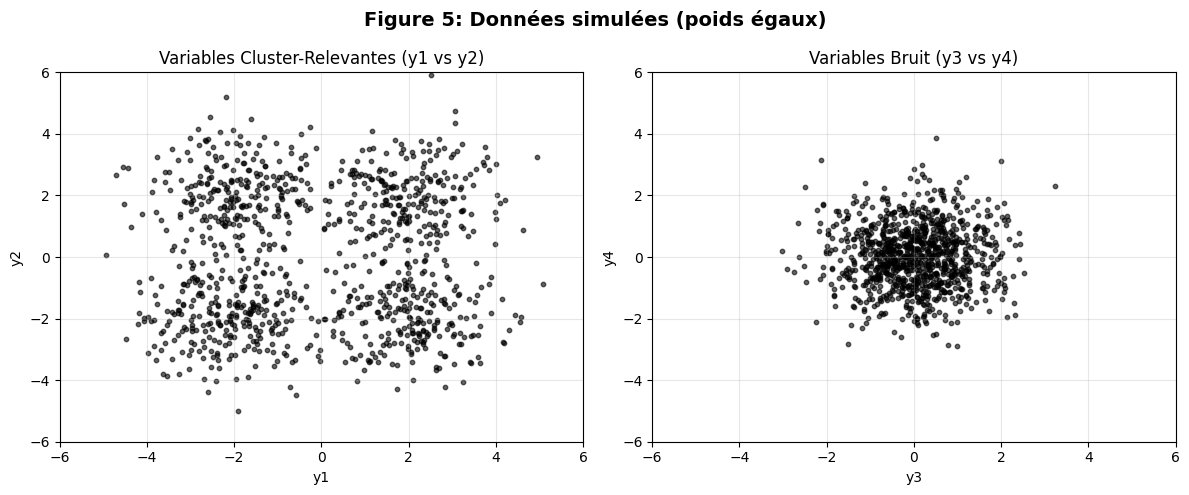


Lancement du MCMC (K=15, 10000 itérations, burn-in=1000)...
Prior Normal-Gamma avec échantillonnage de e0 (Metropolis-Hastings)
Nombre de clusters estimé (Mode K0): 4
Estimation terminée.
Poids finaux : [0.24359475 0.27339573 0.23382059 0.24918892]
Centres finaux : 
[[ 1.99116327  1.87836613 -0.00953048  0.06132306]
 [-2.12517271 -1.89776124  0.03631303 -0.02717534]
 [ 2.01849569 -1.99464312  0.01314869  0.02947373]
 [-1.93387355  2.08170431  0.06713549  0.05913474]]


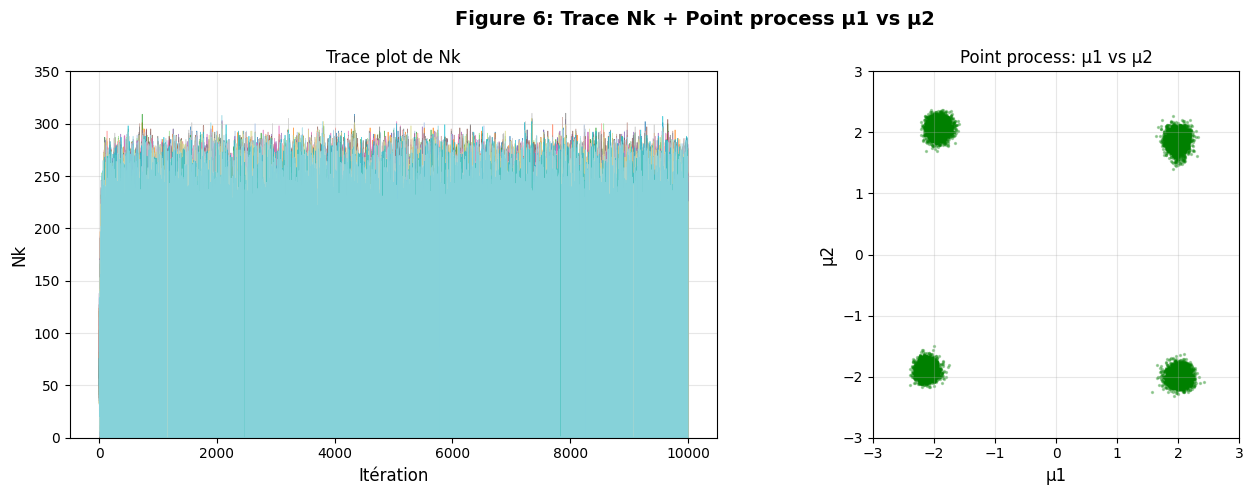

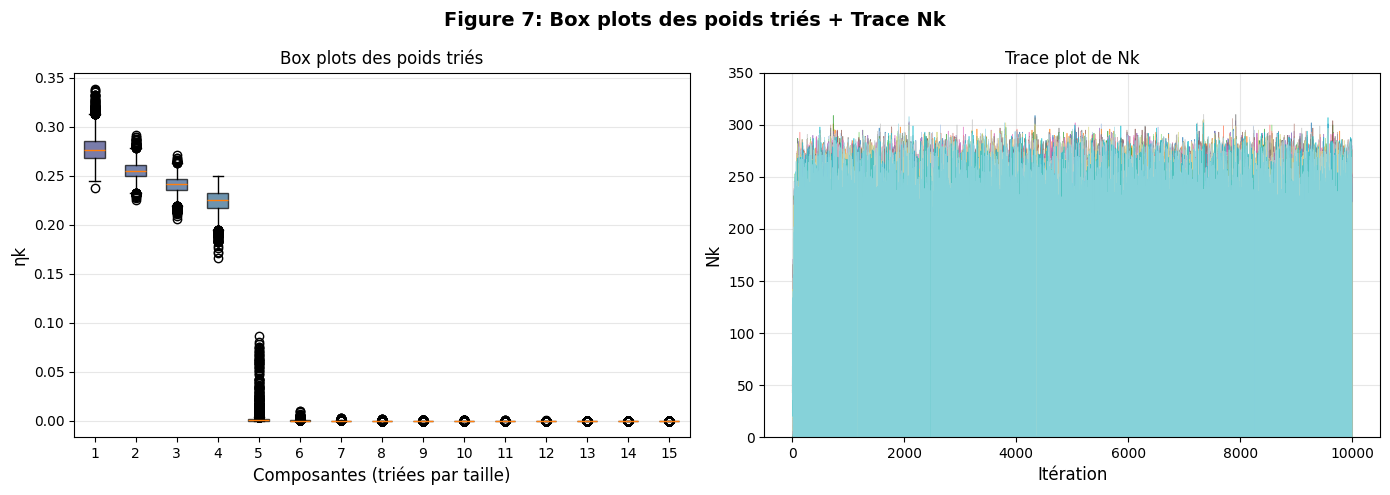

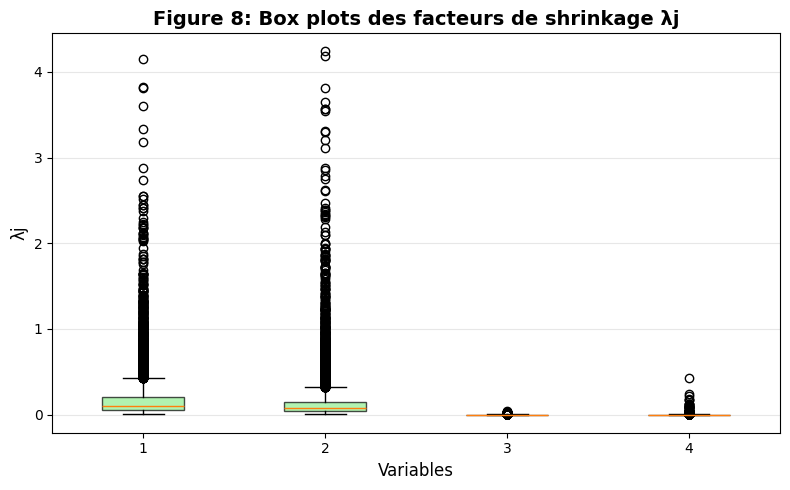

Statistiques des λj:
  Variable 1: médiane=0.0964, IQR=[0.0520, 0.2031]
  Variable 2: médiane=0.0745, IQR=[0.0409, 0.1519]
  Variable 3: médiane=0.0001, IQR=[0.0000, 0.0004]
  Variable 4: médiane=0.0002, IQR=[0.0000, 0.0005]


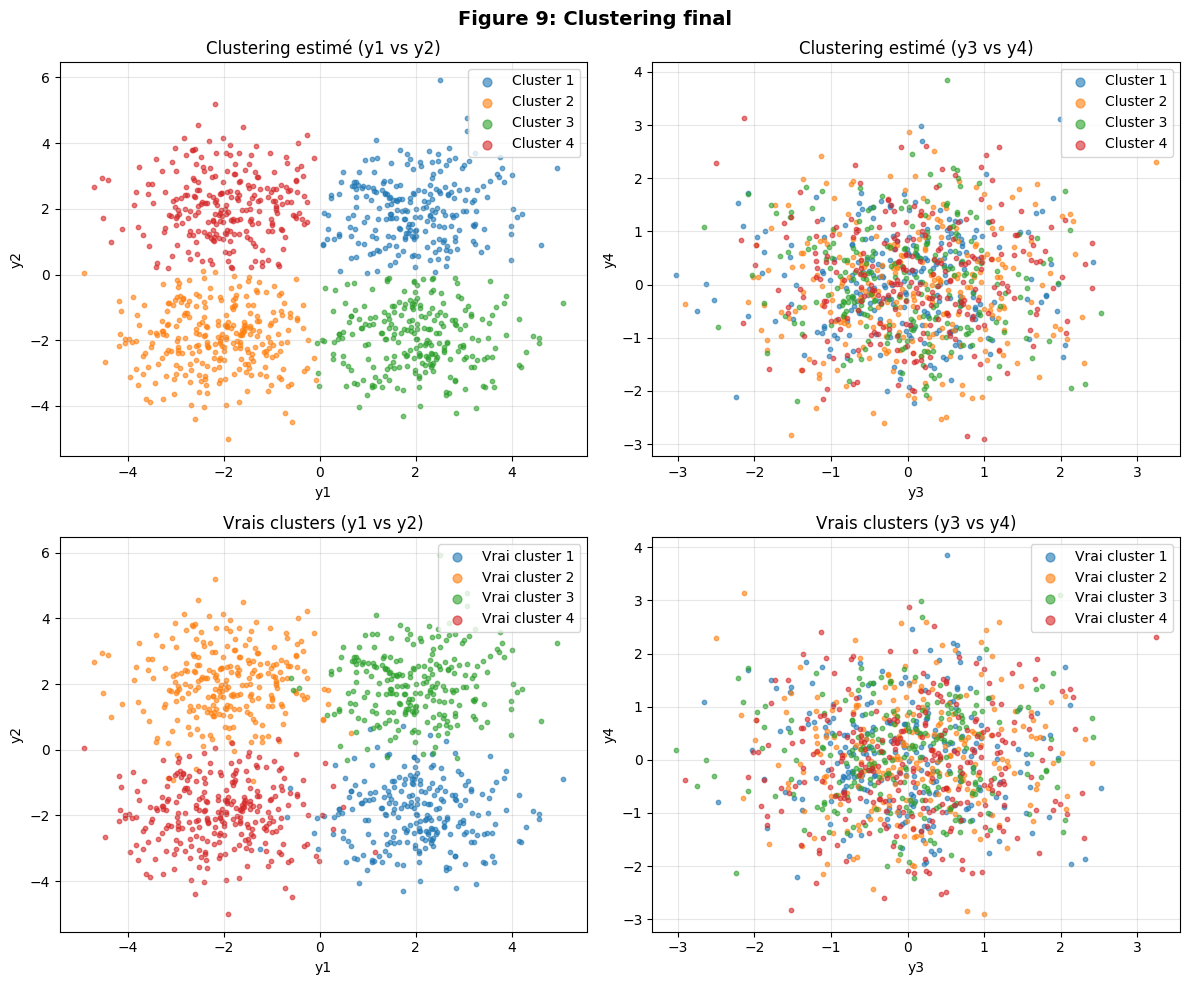

Accuracy du clustering (best permutation): 0.961

RÉSUMÉ DES RÉSULTATS

Nombre de clusters estimé (K̂0): 4
Nombre d'itérations avec K0 = K̂0 (M0): 5329
Proportion de permutations valides (M0,p): 1.000

e0 estimé (moyenne postérieure): 0.0603

Poids estimés (η̂):
  Cluster 1: 0.2436
  Cluster 2: 0.2734
  Cluster 3: 0.2338
  Cluster 4: 0.2492

Centres estimés (μ̂):
  Cluster 1: [ 1.991,  1.878, -0.010,  0.061]
  Cluster 2: [-2.125, -1.898,  0.036, -0.027]
  Cluster 3: [ 2.018, -1.995,  0.013,  0.029]
  Cluster 4: [-1.934,  2.082,  0.067,  0.059]

Vrais centres:
  Cluster 1: [ 2.000, -2.000,  0.000,  0.000]
  Cluster 2: [-2.000,  2.000,  0.000,  0.000]
  Cluster 3: [ 2.000,  2.000,  0.000,  0.000]
  Cluster 4: [-2.000, -2.000,  0.000,  0.000]

MSE_μ: 0.0168
MCR: 0.0370

Facteurs de shrinkage moyens (λ̂):
  y1: λ = 0.1834 ★ CLUSTER-RELEVANTE
  y2: λ = 0.1526 ★ CLUSTER-RELEVANTE
  y3: λ = 0.0005   bruit
  y4: λ = 0.0011   bruit



In [21]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# FONCTIONS DE GÉNÉRATION DE DONNÉES (Section 5.1 du papier)
# =============================================================================

def generate_paper_data(n_samples=1000, scenario='equal', seed=1000):
    """
    Génère les données synthétiques selon la Section 5.1 du papier.
    
    Args:
        n_samples (int): Nombre d'observations (1000 dans le papier)
        scenario (str): 'equal' ou 'unequal' pour les poids des clusters
        seed (int): Graine aléatoire pour reproductibilité
    
    Returns:
        y (np.ndarray): Les observations (N, 4)
        labels (np.ndarray): Les vrais labels (pour vérification)
    """
    np.random.seed(seed)
    
    # 1. Définition des paramètres (Sect 5.1)
    # Moyennes
    # mu1 = (2, -2, 0, 0), mu2 = -mu1, mu3 = (2, 2, 0, 0), mu4 = -mu3
    mu = np.array([
        [ 2, -2, 0, 0],
        [-2,  2, 0, 0],
        [ 2,  2, 0, 0],
        [-2, -2, 0, 0]
    ])
    
    # Covariances (Sigma_k = I_4)
    cov = np.eye(4)
    
    # Poids (Sect 5.1.1 et 5.1.2)
    if scenario == 'equal':
        weights = [0.25, 0.25, 0.25, 0.25]
    elif scenario == 'unequal':
        weights = [0.02, 0.33, 0.33, 0.32]
    else:
        raise ValueError("Scenario doit être 'equal' ou 'unequal'")
        
    # 2. Génération des effectifs par cluster
    n_per_cluster = np.random.multinomial(n_samples, weights)
    
    y_list = []
    labels_list = []
    
    # 3. Échantillonnage des Gaussiennes
    for k, n_k in enumerate(n_per_cluster):
        if n_k > 0:
            cluster_data = np.random.multivariate_normal(mu[k], cov, n_k)
            y_list.append(cluster_data)
            labels_list.append(np.full(n_k, k))
            
    y = np.vstack(y_list)
    labels = np.hstack(labels_list)
    
    # 4. Mélange des données (pour ne pas avoir les clusters ordonnés)
    perm = np.random.permutation(n_samples)
    y = y[perm]
    labels = labels[perm]
    
    return y, labels

# =============================================================================
# FONCTIONS DE VISUALISATION (Figures 5-9 du papier)
# =============================================================================

def plot_figure_5(y, title="Figure 5: Données simulées"):
    """
    Reproduit la Figure 5 du papier :
    - Scatter plot y1 vs y2 (Variables cluster-relevantes)
    - Scatter plot y3 vs y4 (Variables de bruit)
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].scatter(y[:, 0], y[:, 1], s=10, alpha=0.6, c='black')
    axes[0].set_title("Variables Cluster-Relevantes (y1 vs y2)")
    axes[0].set_xlabel("y1")
    axes[0].set_ylabel("y2")
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(-6, 6)
    axes[0].set_ylim(-6, 6)
    
    axes[1].scatter(y[:, 2], y[:, 3], s=10, alpha=0.6, c='black')
    axes[1].set_title("Variables Bruit (y3 vs y4)")
    axes[1].set_xlabel("y3")
    axes[1].set_ylabel("y4")
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(-6, 6)
    axes[1].set_ylim(-6, 6)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_figure_6(model, title="Figure 6: Trace Nk + Point process μ"):
    """
    Reproduit la Figure 6 du papier :
    - Gauche: Trace plot de Nk (nombre d'observations par composante) au cours des itérations
    - Droite: Point process representation de μ1 vs μ2
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gauche: Trace plot de Nk (incluant burn-in)
    all_Nk = np.array(model.all_trace_Nk)
    iterations = np.arange(len(all_Nk))
    
    colors = plt.cm.tab20(np.linspace(0, 1, model.K))
    for k in range(model.K):
        axes[0].plot(iterations, all_Nk[:, k], alpha=0.7, linewidth=0.5, color=colors[k])
    
    axes[0].set_xlabel("Itération", fontsize=12)
    axes[0].set_ylabel("Nk", fontsize=12)
    axes[0].set_title("Trace plot de Nk", fontsize=12)
    axes[0].set_ylim(0, max(all_Nk.max(), 350))
    axes[0].grid(True, alpha=0.3)
    
    # Droite: Point process de μ1 vs μ2
    trace_Nk = np.array(model.trace_Nk)
    K0_list = model.K - np.sum(trace_Nk == 0, axis=1)
    valid_indices = np.where(K0_list == model.K_hat)[0]
    
    all_mus = []
    for idx in valid_indices:
        active_k = np.where(trace_Nk[idx] > 0)[0]
        for k in active_k:
            all_mus.append(model.trace_mu[idx][k])
    
    all_mus = np.array(all_mus)
    
    axes[1].scatter(all_mus[:, 0], all_mus[:, 1], s=2, alpha=0.3, c='green')
    axes[1].set_xlabel("μ1", fontsize=12)
    axes[1].set_ylabel("μ2", fontsize=12)
    axes[1].set_title("Point process: μ1 vs μ2", fontsize=12)
    axes[1].set_xlim(-3, 3)
    axes[1].set_ylim(-3, 3)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_aspect('equal')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_figure_7(model, title="Figure 7: Poids η triés + Trace Nk"):
    """
    Reproduit la Figure 7 du papier :
    - Gauche: Box plots des poids postérieurs triés par taille
    - Droite: Trace plot de Nk au cours des itérations
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gauche: Box plots des poids triés
    trace_eta = np.array(model.trace_eta)
    # Trier les poids par médiane décroissante pour chaque itération
    sorted_etas = np.sort(trace_eta, axis=1)[:, ::-1]  # Tri décroissant
    
    # Box plots
    bp = axes[0].boxplot([sorted_etas[:, k] for k in range(model.K)], 
                         patch_artist=True, showfliers=True)
    
    # Colorer les boxes
    colors_box = plt.cm.viridis(np.linspace(0.2, 0.8, model.K))
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[0].set_xlabel("Composantes (triées par taille)", fontsize=12)
    axes[0].set_ylabel("ηk", fontsize=12)
    axes[0].set_title("Box plots des poids triés", fontsize=12)
    axes[0].set_xticklabels([str(k+1) for k in range(model.K)])
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Droite: Trace plot de Nk
    all_Nk = np.array(model.all_trace_Nk)
    iterations = np.arange(len(all_Nk))
    
    colors = plt.cm.tab20(np.linspace(0, 1, model.K))
    for k in range(model.K):
        axes[1].plot(iterations, all_Nk[:, k], alpha=0.7, linewidth=0.5, color=colors[k])
    
    axes[1].set_xlabel("Itération", fontsize=12)
    axes[1].set_ylabel("Nk", fontsize=12)
    axes[1].set_title("Trace plot de Nk", fontsize=12)
    axes[1].set_ylim(0, max(all_Nk.max(), 350))
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_figure_8(model, var_names=None, title="Figure 8: Box plots des facteurs λj"):
    """
    Reproduit la Figure 8 du papier :
    Box plots des facteurs de shrinkage λj pour chaque variable.
    """
    trace_lambda = np.array(model.trace_lambda)
    r = trace_lambda.shape[1]
    
    if var_names is None:
        var_names = [str(j+1) for j in range(r)]
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Box plots
    bp = ax.boxplot([trace_lambda[:, j] for j in range(r)], 
                    patch_artist=True, showfliers=True)
    
    # Colorer les boxes
    colors_box = ['green' if np.median(trace_lambda[:, j]) > 0.1 else 'lightgreen' 
                  for j in range(r)]
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xlabel("Variables", fontsize=12)
    ax.set_ylabel("λj", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticklabels(var_names)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Afficher les statistiques
    print("Statistiques des λj:")
    for j in range(r):
        med = np.median(trace_lambda[:, j])
        q1, q3 = np.percentile(trace_lambda[:, j], [25, 75])
        print(f"  Variable {var_names[j]}: médiane={med:.4f}, IQR=[{q1:.4f}, {q3:.4f}]")

def plot_figure_8_combined(model_equal, model_unequal, title="Figure 8: λj (poids égaux vs inégaux)"):
    """
    Version combinée de la Figure 8 avec les deux scénarios côte à côte
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for ax, model, subtitle in zip(axes, [model_equal, model_unequal], 
                                    ['Poids égaux', 'Poids inégaux']):
        trace_lambda = np.array(model.trace_lambda)
        r = trace_lambda.shape[1]
        
        bp = ax.boxplot([trace_lambda[:, j] for j in range(r)], 
                        patch_artist=True, showfliers=True)
        
        for patch in bp['boxes']:
            patch.set_facecolor('green')
            patch.set_alpha(0.7)
        
        ax.set_xlabel("Variables", fontsize=12)
        ax.set_ylabel("λj", fontsize=12)
        ax.set_title(subtitle, fontsize=12)
        ax.set_xticklabels([str(j+1) for j in range(r)])
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_figure_9(y, model, true_labels=None, title="Figure 9: Clustering final"):
    """
    Reproduit la Figure 9 du papier :
    Visualisation du clustering final avec les données colorées par cluster assigné.
    """
    # Classifier les données avec les centres estimés
    if hasattr(model, 'final_mu') and model.final_mu is not None:
        # Utiliser les centres finaux pour la classification
        dists = np.zeros((y.shape[0], model.K_hat))
        for k in range(model.K_hat):
            dists[:, k] = np.linalg.norm(y - model.final_mu[k], axis=1)
        predicted_labels = np.argmin(dists, axis=1)
    else:
        # Utiliser le dernier état de S si final_mu n'est pas disponible
        print("Attention: final_mu non disponible, utilisation du dernier état")
        # Fallback: utiliser les derniers mu actifs
        last_Nk = model.trace_Nk[-1]
        last_mu = model.trace_mu[-1]
        active_k = np.where(last_Nk > 0)[0]
        
        dists = np.zeros((y.shape[0], len(active_k)))
        for i, k in enumerate(active_k):
            dists[:, i] = np.linalg.norm(y - last_mu[k], axis=1)
        predicted_labels = np.argmin(dists, axis=1)
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Clustering prédit - y1 vs y2
    for k in range(model.K_hat):
        mask = predicted_labels == k
        axes[0, 0].scatter(y[mask, 0], y[mask, 1], s=10, alpha=0.6, 
                          c=[colors[k % 10]], label=f'Cluster {k+1}')
    axes[0, 0].set_xlabel("y1")
    axes[0, 0].set_ylabel("y2")
    axes[0, 0].set_title("Clustering estimé (y1 vs y2)")
    axes[0, 0].legend(markerscale=2)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Clustering prédit - y3 vs y4
    for k in range(model.K_hat):
        mask = predicted_labels == k
        axes[0, 1].scatter(y[mask, 2], y[mask, 3], s=10, alpha=0.6, 
                          c=[colors[k % 10]], label=f'Cluster {k+1}')
    axes[0, 1].set_xlabel("y3")
    axes[0, 1].set_ylabel("y4")
    axes[0, 1].set_title("Clustering estimé (y3 vs y4)")
    axes[0, 1].legend(markerscale=2)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Vrais labels - y1 vs y2
    if true_labels is not None:
        unique_labels = np.unique(true_labels)
        for k in unique_labels:
            mask = true_labels == k
            axes[1, 0].scatter(y[mask, 0], y[mask, 1], s=10, alpha=0.6, 
                              c=[colors[k % 10]], label=f'Vrai cluster {k+1}')
        axes[1, 0].set_xlabel("y1")
        axes[1, 0].set_ylabel("y2")
        axes[1, 0].set_title("Vrais clusters (y1 vs y2)")
        axes[1, 0].legend(markerscale=2)
        axes[1, 0].grid(True, alpha=0.3)
        
        # Vrais labels - y3 vs y4
        for k in unique_labels:
            mask = true_labels == k
            axes[1, 1].scatter(y[mask, 2], y[mask, 3], s=10, alpha=0.6, 
                              c=[colors[k % 10]], label=f'Vrai cluster {k+1}')
        axes[1, 1].set_xlabel("y3")
        axes[1, 1].set_ylabel("y4")
        axes[1, 1].set_title("Vrais clusters (y3 vs y4)")
        axes[1, 1].legend(markerscale=2)
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Calcul de l'accuracy (en tenant compte des permutations)
    if true_labels is not None:
        from itertools import permutations
        best_acc = 0
        for perm in permutations(range(model.K_hat)):
            relabeled = np.array([perm[l] for l in predicted_labels])
            acc = np.mean(relabeled == true_labels)
            best_acc = max(best_acc, acc)
        print(f"Accuracy du clustering (best permutation): {best_acc:.3f}")

def print_table_row(model, true_mu, true_labels, prior_type="Ng", e0_fixed=None):
    """Affiche une ligne de tableau comme Table 1/2 du papier"""
    # Calculer MSE et MCR
    mse = model.compute_mse(true_mu)
    mcr = model.compute_mcr_with_true_labels(true_labels)
    
    e0_est = f"{model.e0_estimated:.2f}" if model.sample_e0 else "-"
    e0_fix = f"{e0_fixed}" if e0_fixed else f"{model.e0}"
    k_hat = model.K_hat
    m0 = model.M0 if hasattr(model, 'M0') else "-"
    m0_p = f"{model.M0_p:.2f}" if hasattr(model, 'M0_p') else "-"
    
    print(f"| {prior_type:6} | {model.K:3} | {e0_est:6} | {e0_fix:8} | {k_hat:4} | {m0:6} | {m0_p:6} | {mcr:.3f} | {mse:.3f} |")
    
    return {'K': model.K, 'e0_est': model.e0_estimated if model.sample_e0 else None,
            'e0_fixed': e0_fixed or model.e0, 'K_hat': k_hat, 'M0': m0, 
            'M0_p': model.M0_p if hasattr(model, 'M0_p') else None,
            'MCR': mcr, 'MSE_mu': mse}

def print_table_header():
    """Affiche l'en-tête du tableau comme Table 1/2"""
    print("\n" + "="*80)
    print("| Prior  |  K  |  ê0   | e0 fixed |  K̂0  |   M0   |  M0,p  |  MCR  | MSE_μ |")
    print("|" + "-"*78 + "|")

def print_summary(model, true_mu=None, true_labels=None):
    """Affiche un résumé des résultats comme dans le papier"""
    print("\n" + "="*70)
    print("RÉSUMÉ DES RÉSULTATS")
    print("="*70)
    
    print(f"\nNombre de clusters estimé (K̂0): {model.K_hat}")
    print(f"Nombre d'itérations avec K0 = K̂0 (M0): {model.M0 if hasattr(model, 'M0') else 'N/A'}")
    print(f"Proportion de permutations valides (M0,p): {model.M0_p:.3f}" if hasattr(model, 'M0_p') else "")
    
    if model.sample_e0:
        print(f"\ne0 estimé (moyenne postérieure): {model.e0_estimated:.4f}")
    else:
        print(f"\ne0 fixé: {model.e0}")
    
    if hasattr(model, 'final_eta') and model.final_eta is not None:
        print(f"\nPoids estimés (η̂):")
        for k, eta in enumerate(model.final_eta):
            print(f"  Cluster {k+1}: {eta:.4f}")
    
    if hasattr(model, 'final_mu') and model.final_mu is not None:
        print(f"\nCentres estimés (μ̂):")
        for k, mu in enumerate(model.final_mu):
            print(f"  Cluster {k+1}: [{mu[0]:6.3f}, {mu[1]:6.3f}, {mu[2]:6.3f}, {mu[3]:6.3f}]")
        
        if true_mu is not None:
            print(f"\nVrais centres:")
            for k, mu in enumerate(true_mu):
                print(f"  Cluster {k+1}: [{mu[0]:6.3f}, {mu[1]:6.3f}, {mu[2]:6.3f}, {mu[3]:6.3f}]")
            
            # MSE
            mse = model.compute_mse(true_mu)
            print(f"\nMSE_μ: {mse:.4f}")
    
    # MCR
    if true_labels is not None and hasattr(model, 'predicted_labels'):
        mcr = model.compute_mcr_with_true_labels(true_labels)
        print(f"MCR: {mcr:.4f}")
    
    # Shrinkage factors
    if hasattr(model, 'trace_lambda') and len(model.trace_lambda) > 0:
        mean_lambda = np.mean(model.trace_lambda, axis=0)
        print(f"\nFacteurs de shrinkage moyens (λ̂):")
        var_names = ['y1', 'y2', 'y3', 'y4']
        for j, (name, lam) in enumerate(zip(var_names, mean_lambda)):
            relevance = "★ CLUSTER-RELEVANTE" if lam > 0.1 else "  bruit"
            print(f"  {name}: λ = {lam:.4f} {relevance}")
    
    print("\n" + "="*70)

# =============================================================================
# EXÉCUTION DES TESTS (Section 5.1 du papier)
# =============================================================================

# Paramètres comme dans le papier
TRUE_MU = np.array([
    [ 2, -2, 0, 0],
    [-2,  2, 0, 0],
    [ 2,  2, 0, 0],
    [-2, -2, 0, 0]
])

print("="*70)
print("TEST 1: Scénario 'equal weights' (Section 5.1.1)")
print("Prior: Normal-Gamma (Ng) avec échantillonnage de e0")
print("="*70)

# Génération des données
y_sim, true_labels = generate_paper_data(n_samples=1000, scenario='equal', seed=42)

# Figure 5: Données simulées
plot_figure_5(y_sim, "Figure 5: Données simulées (poids égaux)")

# Entraînement du modèle avec échantillonnage de e0
print("\nLancement du MCMC (K=15, 10000 itérations, burn-in=1000)...")
print("Prior Normal-Gamma avec échantillonnage de e0 (Metropolis-Hastings)")

model = SparseGaussianMixture(K=15, e0=0.01, c0=2.5 + (4-1)/2, nu1=0.5, nu2=0.5, sample_e0=True)
model.fit(y_sim, max_iter=10000, burn_in=1000)

# Figure 6: Trace Nk + Point process
plot_figure_6(model, "Figure 6: Trace Nk + Point process μ1 vs μ2")

# Figure 7: Box plots poids + Trace Nk
plot_figure_7(model, "Figure 7: Box plots des poids triés + Trace Nk")

# Figure 8: Box plots des λj
plot_figure_8(model, var_names=['1', '2', '3', '4'], 
              title="Figure 8: Box plots des facteurs de shrinkage λj")

# Figure 9: Clustering final
plot_figure_9(y_sim, model, true_labels, "Figure 9: Clustering final")

# Résumé complet
print_summary(model, TRUE_MU, true_labels)


TEST 2: Scénario 'unequal weights' (Section 5.1.2)
Poids: [0.02, 0.33, 0.33, 0.32] - Un cluster minoritaire
Prior: Normal-Gamma (Ng) avec échantillonnage de e0


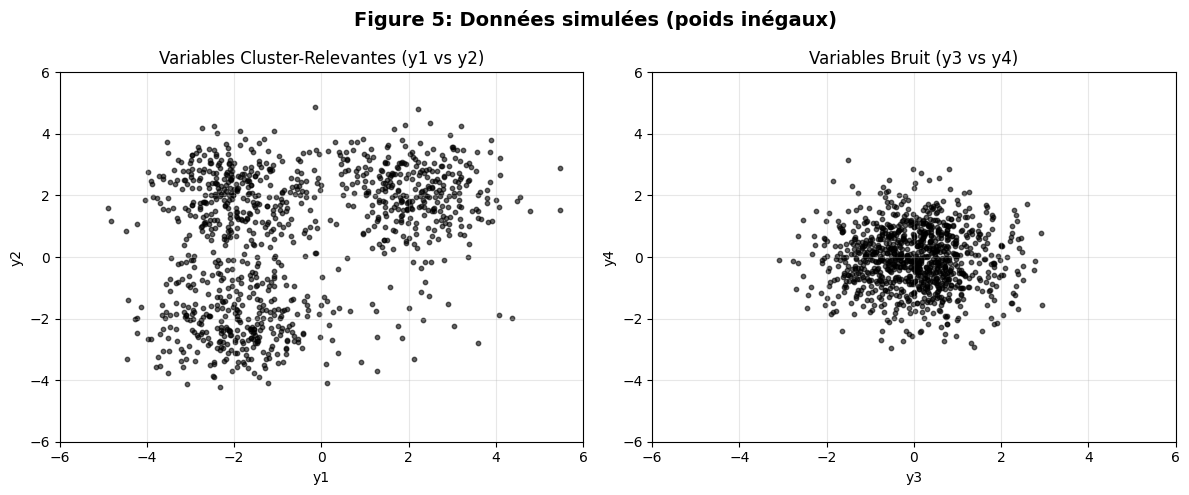


Lancement du MCMC (K=15, 10000 itérations, burn-in=1000)...
Nombre de clusters estimé (Mode K0): 4
Estimation terminée.
Poids finaux : [0.33474965 0.02588997 0.32148154 0.31787885]
Centres finaux : 
[[-2.01247928e+00  1.98264127e+00 -4.42796838e-02 -3.03796905e-02]
 [ 1.67316877e+00 -1.69195022e+00 -1.13044468e-02  2.46173505e-02]
 [ 2.07386842e+00  2.13452090e+00  6.79968963e-02 -9.41248073e-02]
 [-1.94335372e+00 -2.01414488e+00 -1.73884372e-03 -4.49715978e-02]]


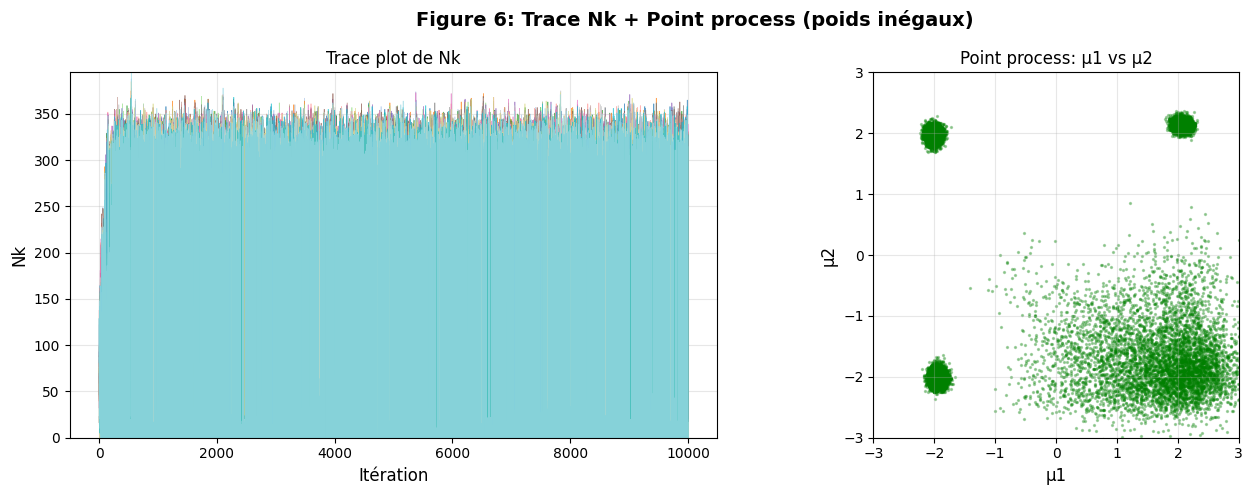

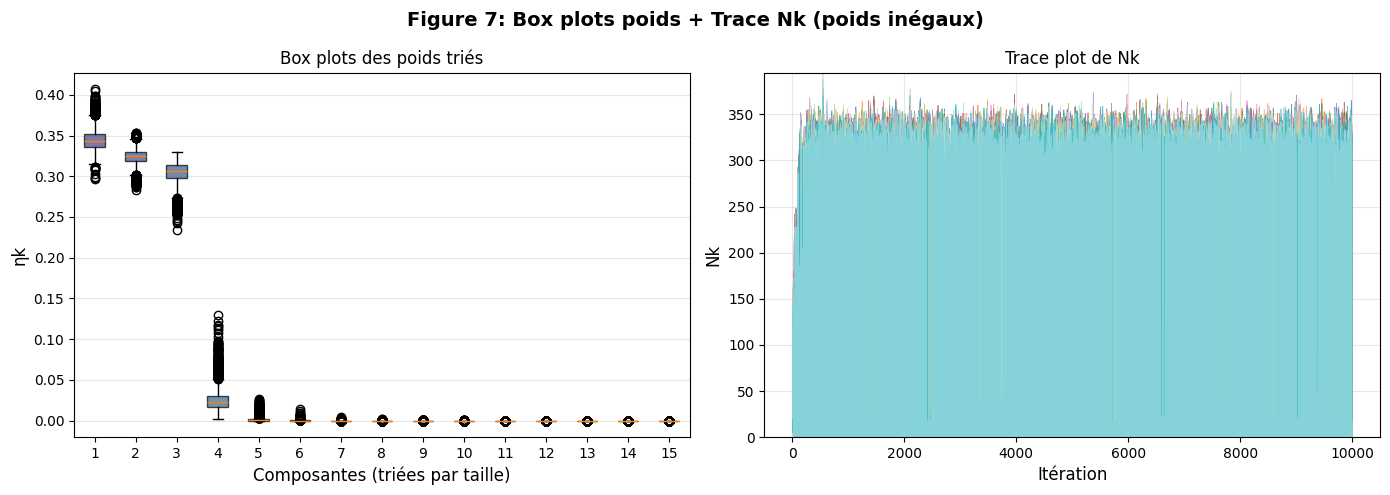

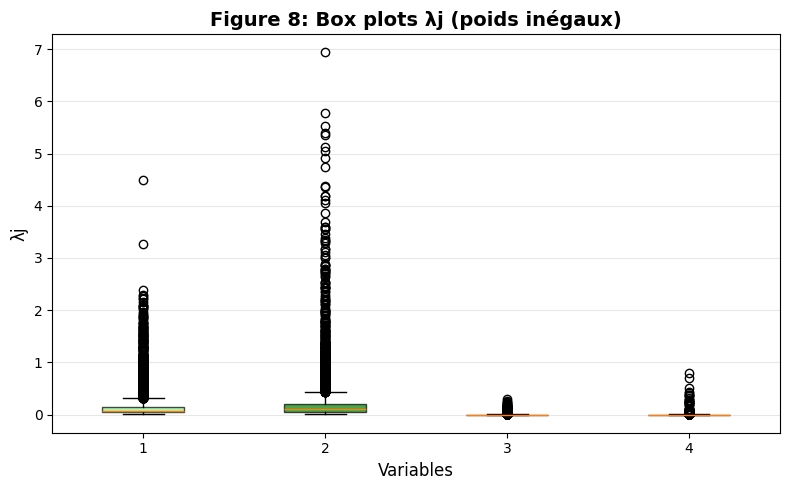

Statistiques des λj:
  Variable 1: médiane=0.0769, IQR=[0.0427, 0.1516]
  Variable 2: médiane=0.1064, IQR=[0.0592, 0.2111]
  Variable 3: médiane=0.0003, IQR=[0.0001, 0.0011]
  Variable 4: médiane=0.0002, IQR=[0.0000, 0.0011]


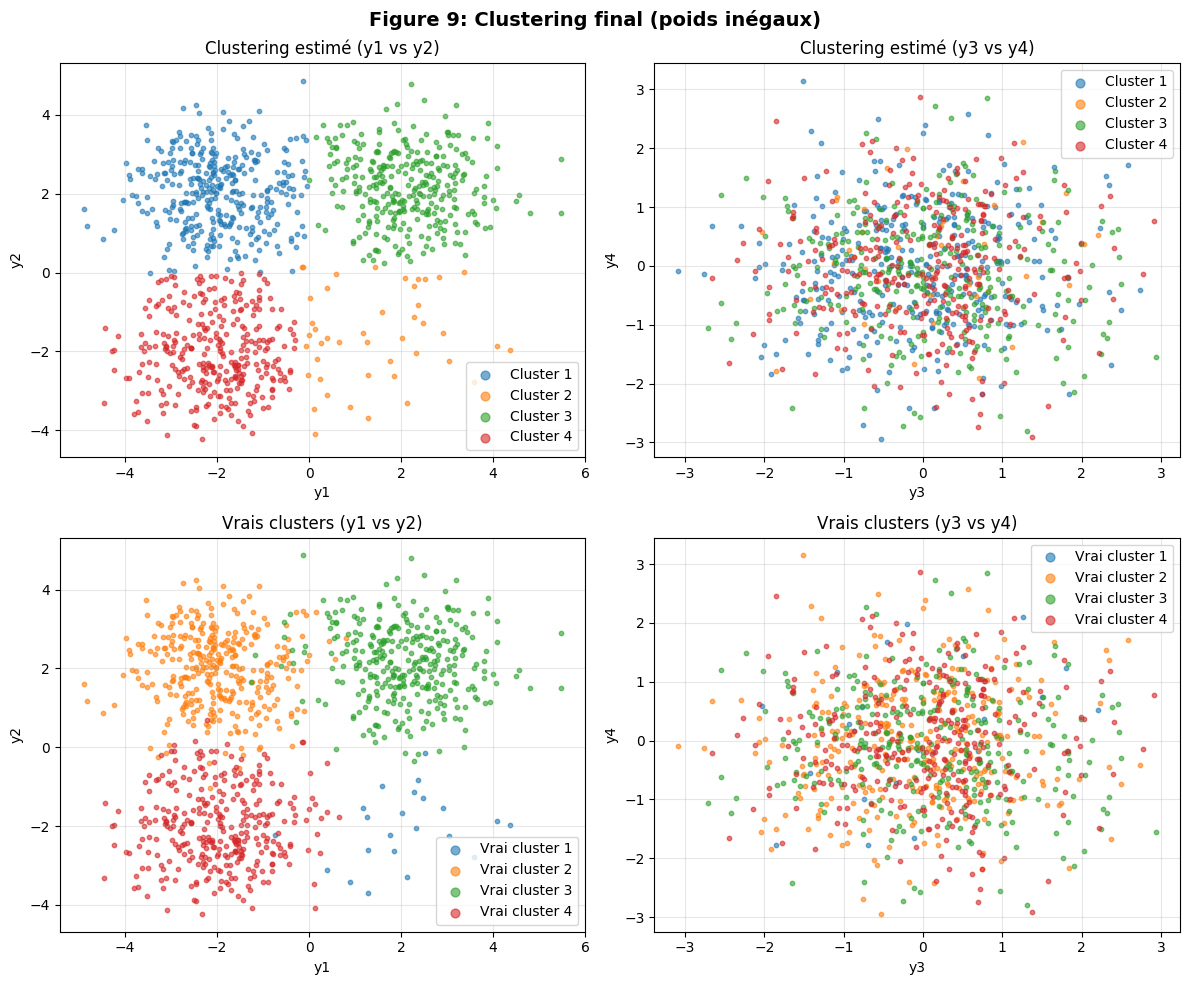

Accuracy du clustering (best permutation): 0.945

RÉSUMÉ DES RÉSULTATS

Nombre de clusters estimé (K̂0): 4
Nombre d'itérations avec K0 = K̂0 (M0): 5884
Proportion de permutations valides (M0,p): 0.998

e0 estimé (moyenne postérieure): 0.0602

Poids estimés (η̂):
  Cluster 1: 0.3347
  Cluster 2: 0.0259
  Cluster 3: 0.3215
  Cluster 4: 0.3179

Centres estimés (μ̂):
  Cluster 1: [-2.012,  1.983, -0.044, -0.030]
  Cluster 2: [ 1.673, -1.692, -0.011,  0.025]
  Cluster 3: [ 2.074,  2.135,  0.068, -0.094]
  Cluster 4: [-1.943, -2.014, -0.002, -0.045]

Vrais centres:
  Cluster 1: [ 2.000, -2.000,  0.000,  0.000]
  Cluster 2: [-2.000,  2.000,  0.000,  0.000]
  Cluster 3: [ 2.000,  2.000,  0.000,  0.000]
  Cluster 4: [-2.000, -2.000,  0.000,  0.000]

MSE_μ: 0.0621
MCR: 0.0390

Facteurs de shrinkage moyens (λ̂):
  y1: λ = 0.1474 ★ CLUSTER-RELEVANTE
  y2: λ = 0.2063 ★ CLUSTER-RELEVANTE
  y3: λ = 0.0023   bruit
  y4: λ = 0.0027   bruit


FIGURE 8 COMBINÉE: Comparaison λj entre les deux scénarios


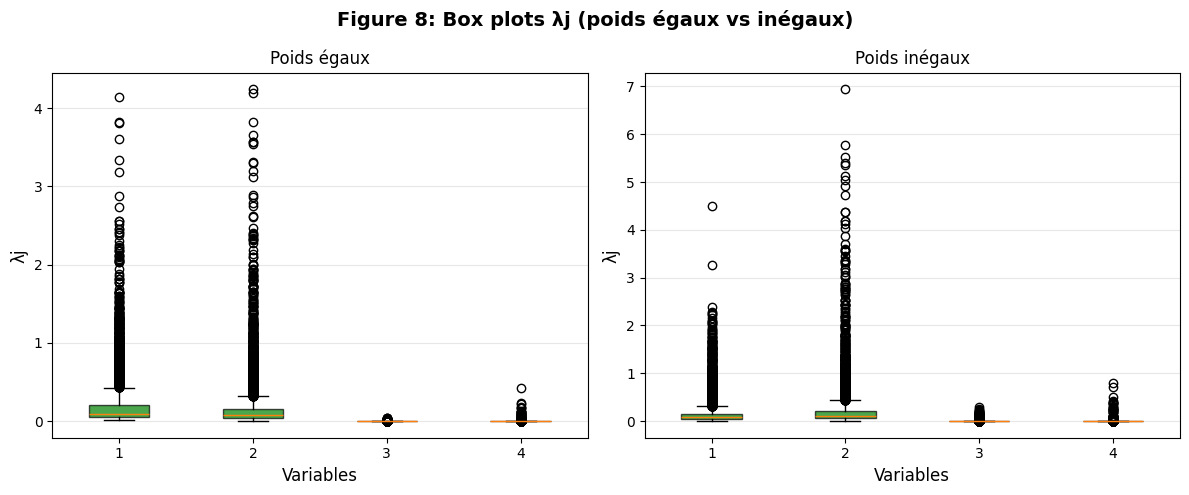



TABLEAU RÉCAPITULATIF (comme Table 1/2 du papier)

| Prior  |  K  |  ê0   | e0 fixed |  K̂0  |   M0   |  M0,p  |  MCR  | MSE_μ |
|------------------------------------------------------------------------------|
| Ng     |  15 | 0.06   | 0.01     |    4 |   5329 | 1.00   | 0.037 | 0.017 |
| Ng     |  15 | 0.06   | 0.01     |    4 |   5884 | 1.00   | 0.039 | 0.062 |


In [22]:
# =============================================================================
# TEST 2: Scénario 'unequal weights' (Section 5.1.2 du papier)
# =============================================================================

print("\n" + "="*70)
print("TEST 2: Scénario 'unequal weights' (Section 5.1.2)")
print("Poids: [0.02, 0.33, 0.33, 0.32] - Un cluster minoritaire")
print("Prior: Normal-Gamma (Ng) avec échantillonnage de e0")
print("="*70)

# Génération des données avec poids inégaux
y_sim_uneq, true_labels_uneq = generate_paper_data(n_samples=1000, scenario='unequal', seed=123)

# Figure 5: Données simulées
plot_figure_5(y_sim_uneq, "Figure 5: Données simulées (poids inégaux)")

# Entraînement du modèle avec échantillonnage de e0
print("\nLancement du MCMC (K=15, 10000 itérations, burn-in=1000)...")
model_uneq = SparseGaussianMixture(K=15, e0=0.01, c0=2.5 + (4-1)/2, nu1=0.5, nu2=0.5, sample_e0=True)
model_uneq.fit(y_sim_uneq, max_iter=10000, burn_in=1000)

# Figures
plot_figure_6(model_uneq, "Figure 6: Trace Nk + Point process (poids inégaux)")
plot_figure_7(model_uneq, "Figure 7: Box plots poids + Trace Nk (poids inégaux)")
plot_figure_8(model_uneq, var_names=['1', '2', '3', '4'], 
              title="Figure 8: Box plots λj (poids inégaux)")
plot_figure_9(y_sim_uneq, model_uneq, true_labels_uneq, "Figure 9: Clustering final (poids inégaux)")

# Résumé
print_summary(model_uneq, TRUE_MU, true_labels_uneq)

# =============================================================================
# Figure 8 combinée (comme dans le papier)
# =============================================================================
print("\n" + "="*70)
print("FIGURE 8 COMBINÉE: Comparaison λj entre les deux scénarios")
print("="*70)
plot_figure_8_combined(model, model_uneq, "Figure 8: Box plots λj (poids égaux vs inégaux)")

# =============================================================================
# TABLEAU RÉCAPITULATIF (comme Table 1/2 du papier)
# =============================================================================
print("\n")
print("="*80)
print("TABLEAU RÉCAPITULATIF (comme Table 1/2 du papier)")
print("="*80)
print_table_header()
print_table_row(model, TRUE_MU, true_labels, prior_type="Ng", e0_fixed=None)
print_table_row(model_uneq, TRUE_MU, true_labels_uneq, prior_type="Ng", e0_fixed=None)
print("="*80)



SECTION 5.2: CRABS DATA
200 observations, 5 variables, 4 groupes (espèce × sexe)
Chargement des données Crabs depuis URL...

Dimensions: (200, 9)
   rownames sp sex  index   FL   RW    CL    CW   BD
0         1  B   M      1  8.1  6.7  16.1  19.0  7.0
1         2  B   M      2  8.8  7.7  18.1  20.8  7.4
2         3  B   M      3  9.2  7.8  19.0  22.4  7.7
3         4  B   M      4  9.6  7.9  20.1  23.1  8.2
4         5  B   M      5  9.8  8.0  20.3  23.0  8.2

Groupes: ['B_F' 'B_M' 'O_F' 'O_M']
Tailles des groupes: [50 50 50 50]

Données standardisées: mean=[-0.  0.  0. -0.  0.], std=[1. 1. 1. 1. 1.]


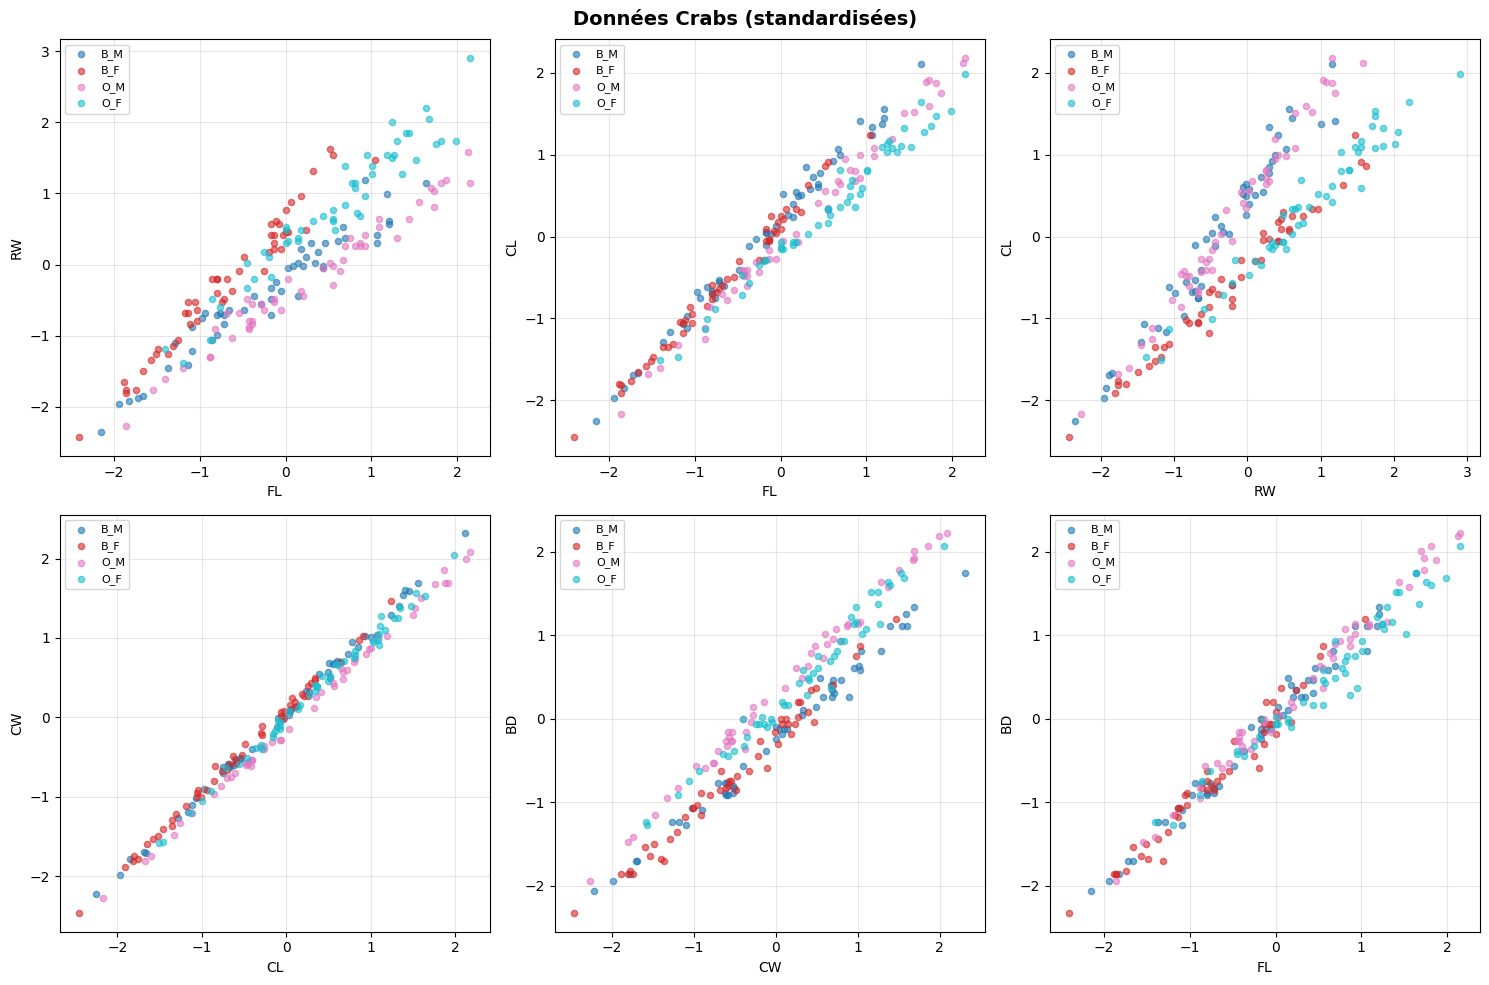


----------------------------------------------------------------------
Entraînement du modèle sparse GMM sur Crabs
K=30, Normal-Gamma prior, échantillonnage de e0
----------------------------------------------------------------------
Nombre de clusters estimé (Mode K0): 2
Estimation terminée.
Poids finaux : [0.50081991 0.49918009]
Centres finaux : 
[[ 0.39733182  0.27631599  0.24691276  0.17459916  0.38347641]
 [-0.40180637 -0.28105336 -0.24786194 -0.17452425 -0.38644581]]


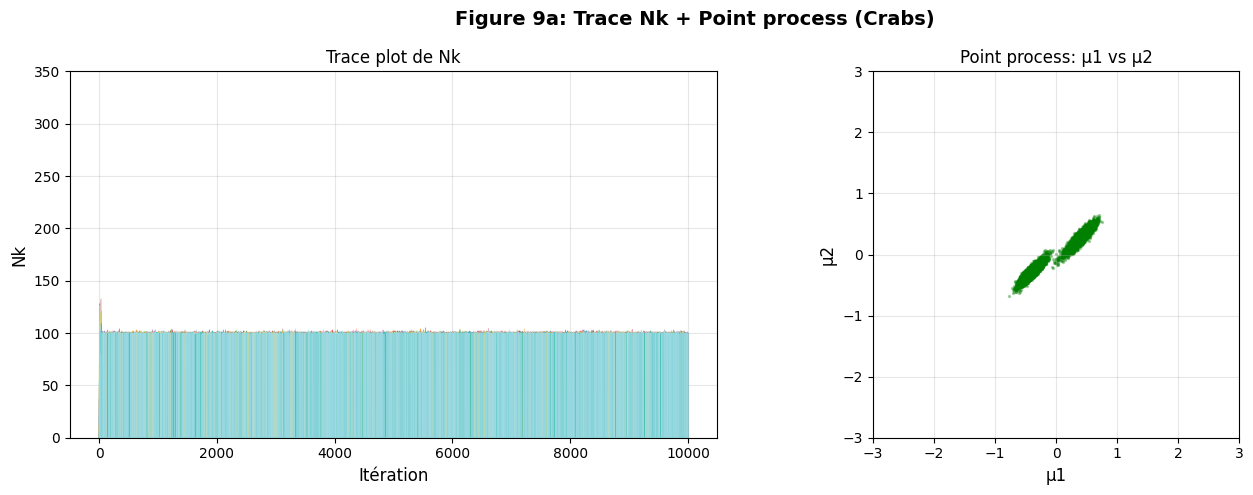

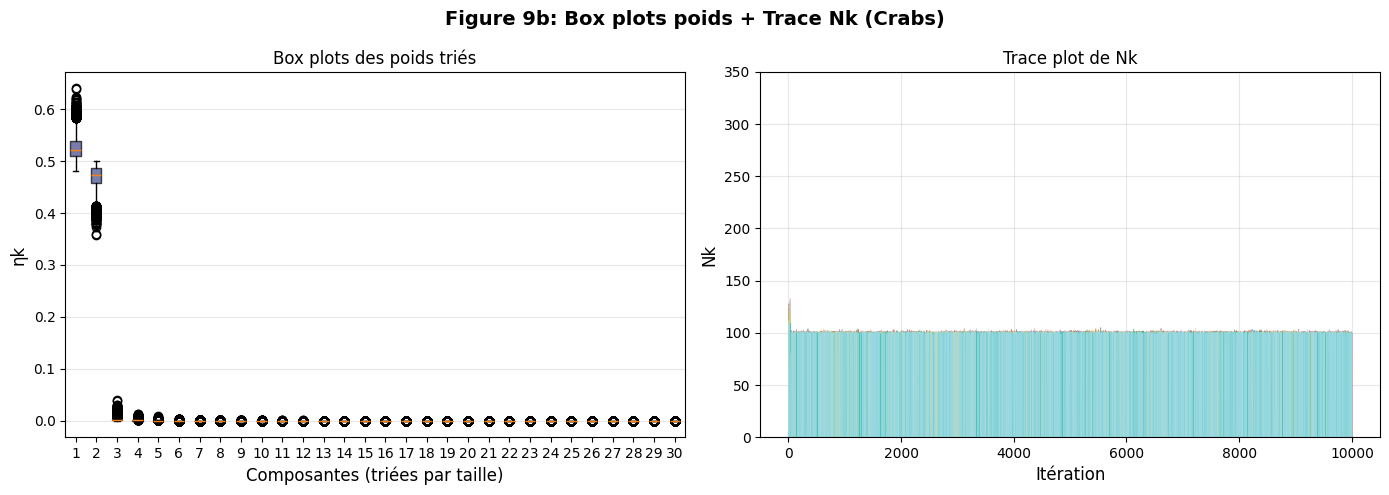

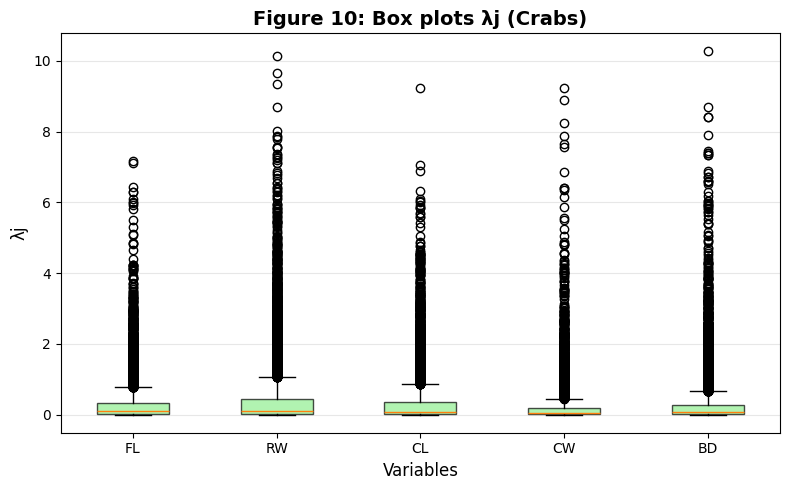

Statistiques des λj:
  Variable FL: médiane=0.0899, IQR=[0.0271, 0.3239]
  Variable RW: médiane=0.0935, IQR=[0.0190, 0.4374]
  Variable CL: médiane=0.0728, IQR=[0.0155, 0.3584]
  Variable CW: médiane=0.0374, IQR=[0.0066, 0.1856]
  Variable BD: médiane=0.0849, IQR=[0.0267, 0.2785]

RÉSULTATS CRABS
Nombre de clusters estimé (K̂0): 2
M0: 8975
M0,p: 1.000
ê0 (moyenne postérieure): 0.0251
MCR: 0.7500

Facteurs de shrinkage λj:
  FL: λ = 0.0899 
  RW: λ = 0.0935 
  CL: λ = 0.0728 
  CW: λ = 0.0374 
  BD: λ = 0.0849 

Poids estimés (η̂):
  Cluster 1: 0.5008
  Cluster 2: 0.4992


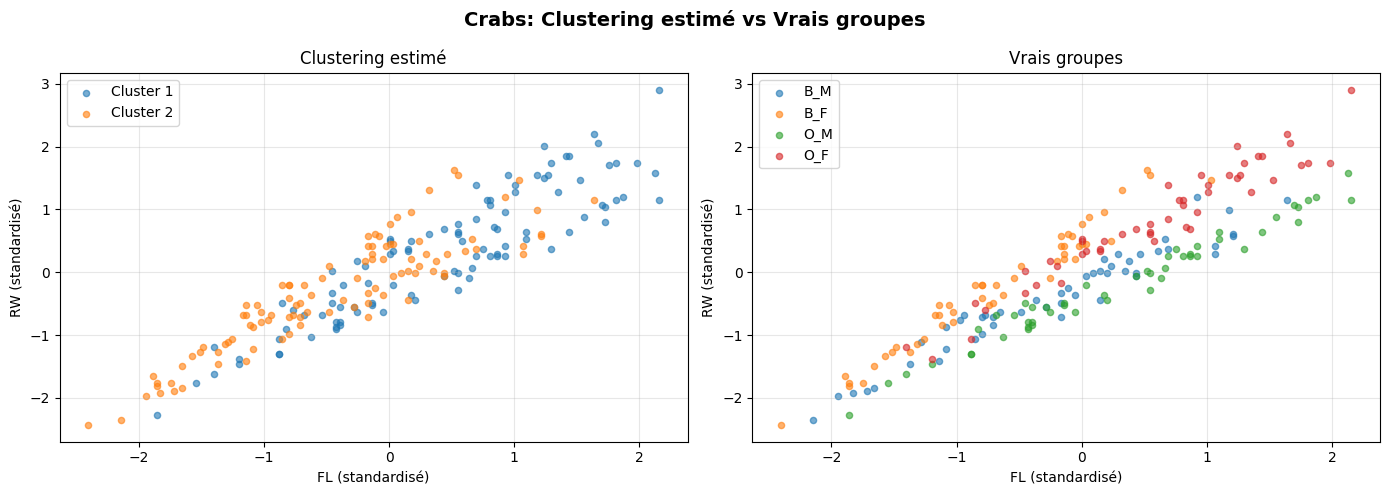

In [23]:
# =============================================================================
# SECTION 5.2: CRABS DATA (Leptograpsus crabs)
# =============================================================================
# Dataset: 200 observations, 5 variables morphologiques
# 4 groupes: 2 espèces (Blue, Orange) × 2 sexes (Male, Female)
# Variables: FL (frontal lobe), RW (rear width), CL (carapace length), 
#            CW (carapace width), BD (body depth)

print("\n" + "="*70)
print("SECTION 5.2: CRABS DATA")
print("200 observations, 5 variables, 4 groupes (espèce × sexe)")
print("="*70)

# Charger les données Crabs depuis R datasets (via statsmodels ou manuellement)
try:
    import statsmodels.api as sm
    crabs_data = sm.datasets.get_rdataset("crabs", "MASS").data
    print("Données Crabs chargées depuis statsmodels/MASS")
except:
    # Fallback: charger depuis URL ou créer manuellement
    print("Chargement des données Crabs depuis URL...")
    import pandas as pd
    url = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/MASS/crabs.csv"
    crabs_data = pd.read_csv(url)

# Afficher les premières lignes
print(f"\nDimensions: {crabs_data.shape}")
print(crabs_data.head())

# Préparer les données
# Variables morphologiques (colonnes 4-8 dans le dataset MASS)
var_names_crabs = ['FL', 'RW', 'CL', 'CW', 'BD']
y_crabs = crabs_data[var_names_crabs].values

# Créer les vrais labels (sp × sex combinés)
# sp: B=Blue, O=Orange; sex: M=Male, F=Female
crabs_data['group'] = crabs_data['sp'].astype(str) + '_' + crabs_data['sex'].astype(str)
group_mapping = {'B_M': 0, 'B_F': 1, 'O_M': 2, 'O_F': 3}
true_labels_crabs = crabs_data['group'].map(group_mapping).values

print(f"\nGroupes: {np.unique(crabs_data['group'])}")
print(f"Tailles des groupes: {np.bincount(true_labels_crabs)}")

# Standardiser les données (comme dans le papier)
from sklearn.preprocessing import StandardScaler
scaler_crabs = StandardScaler()
y_crabs_scaled = scaler_crabs.fit_transform(y_crabs)

print(f"\nDonnées standardisées: mean={y_crabs_scaled.mean(axis=0).round(3)}, std={y_crabs_scaled.std(axis=0).round(3)}")

# Visualisation des données
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
colors = plt.cm.tab10(np.linspace(0, 1, 4))

# Scatter plots des paires de variables
pairs = [(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (0, 4)]
for idx, (i, j) in enumerate(pairs):
    ax = axes[idx // 3, idx % 3]
    for g in range(4):
        mask = true_labels_crabs == g
        ax.scatter(y_crabs_scaled[mask, i], y_crabs_scaled[mask, j], 
                   s=20, alpha=0.6, c=[colors[g]], label=list(group_mapping.keys())[g])
    ax.set_xlabel(var_names_crabs[i])
    ax.set_ylabel(var_names_crabs[j])
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle("Données Crabs (standardisées)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Entraînement du modèle (comme Table 3 du papier)
print("\n" + "-"*70)
print("Entraînement du modèle sparse GMM sur Crabs")
print("K=30, Normal-Gamma prior, échantillonnage de e0")
print("-"*70)

model_crabs = SparseGaussianMixture(K=30, e0=0.01, c0=2.5 + (5-1)/2, nu1=0.5, nu2=0.5, sample_e0=True)
model_crabs.fit(y_crabs_scaled, max_iter=10000, burn_in=1000)

# Figures comme dans le papier
plot_figure_6(model_crabs, "Figure 9a: Trace Nk + Point process (Crabs)")
plot_figure_7(model_crabs, "Figure 9b: Box plots poids + Trace Nk (Crabs)")
plot_figure_8(model_crabs, var_names=var_names_crabs, title="Figure 10: Box plots λj (Crabs)")

# Résumé
print("\n" + "="*70)
print("RÉSULTATS CRABS")
print("="*70)
print(f"Nombre de clusters estimé (K̂0): {model_crabs.K_hat}")
print(f"M0: {model_crabs.M0}")
print(f"M0,p: {model_crabs.M0_p:.3f}")
if model_crabs.sample_e0:
    print(f"ê0 (moyenne postérieure): {model_crabs.e0_estimated:.4f}")

# MCR
mcr_crabs = model_crabs.compute_mcr_with_true_labels(true_labels_crabs)
print(f"MCR: {mcr_crabs:.4f}")

# Facteurs de shrinkage
print("\nFacteurs de shrinkage λj:")
trace_lambda = np.array(model_crabs.trace_lambda)
for j, name in enumerate(var_names_crabs):
    med = np.median(trace_lambda[:, j])
    print(f"  {name}: λ = {med:.4f} {'★ RELEVANTE' if med > 0.1 else ''}")

# Poids estimés
if hasattr(model_crabs, 'final_eta') and model_crabs.final_eta is not None:
    print(f"\nPoids estimés (η̂):")
    sorted_eta = np.sort(model_crabs.final_eta)[::-1]
    for k, eta in enumerate(sorted_eta):
        if eta > 0.01:
            print(f"  Cluster {k+1}: {eta:.4f}")

# Visualisation du clustering final
if hasattr(model_crabs, 'predicted_labels'):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Clustering estimé
    for k in range(model_crabs.K_hat):
        mask = model_crabs.predicted_labels == k
        axes[0].scatter(y_crabs_scaled[mask, 0], y_crabs_scaled[mask, 1], 
                       s=20, alpha=0.6, label=f'Cluster {k+1}')
    axes[0].set_xlabel('FL (standardisé)')
    axes[0].set_ylabel('RW (standardisé)')
    axes[0].set_title('Clustering estimé')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Vrais groupes
    for g in range(4):
        mask = true_labels_crabs == g
        axes[1].scatter(y_crabs_scaled[mask, 0], y_crabs_scaled[mask, 1], 
                       s=20, alpha=0.6, label=list(group_mapping.keys())[g])
    axes[1].set_xlabel('FL (standardisé)')
    axes[1].set_ylabel('RW (standardisé)')
    axes[1].set_title('Vrais groupes')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle("Crabs: Clustering estimé vs Vrais groupes", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()



SECTION 5.3: IRIS DATA
150 observations, 4 variables, 3 espèces

Dimensions: (150, 4)
Espèces: ['setosa' 'versicolor' 'virginica']
Tailles des groupes: [50 50 50]

Données standardisées: mean=[-0. -0. -0. -0.], std=[1. 1. 1. 1.]


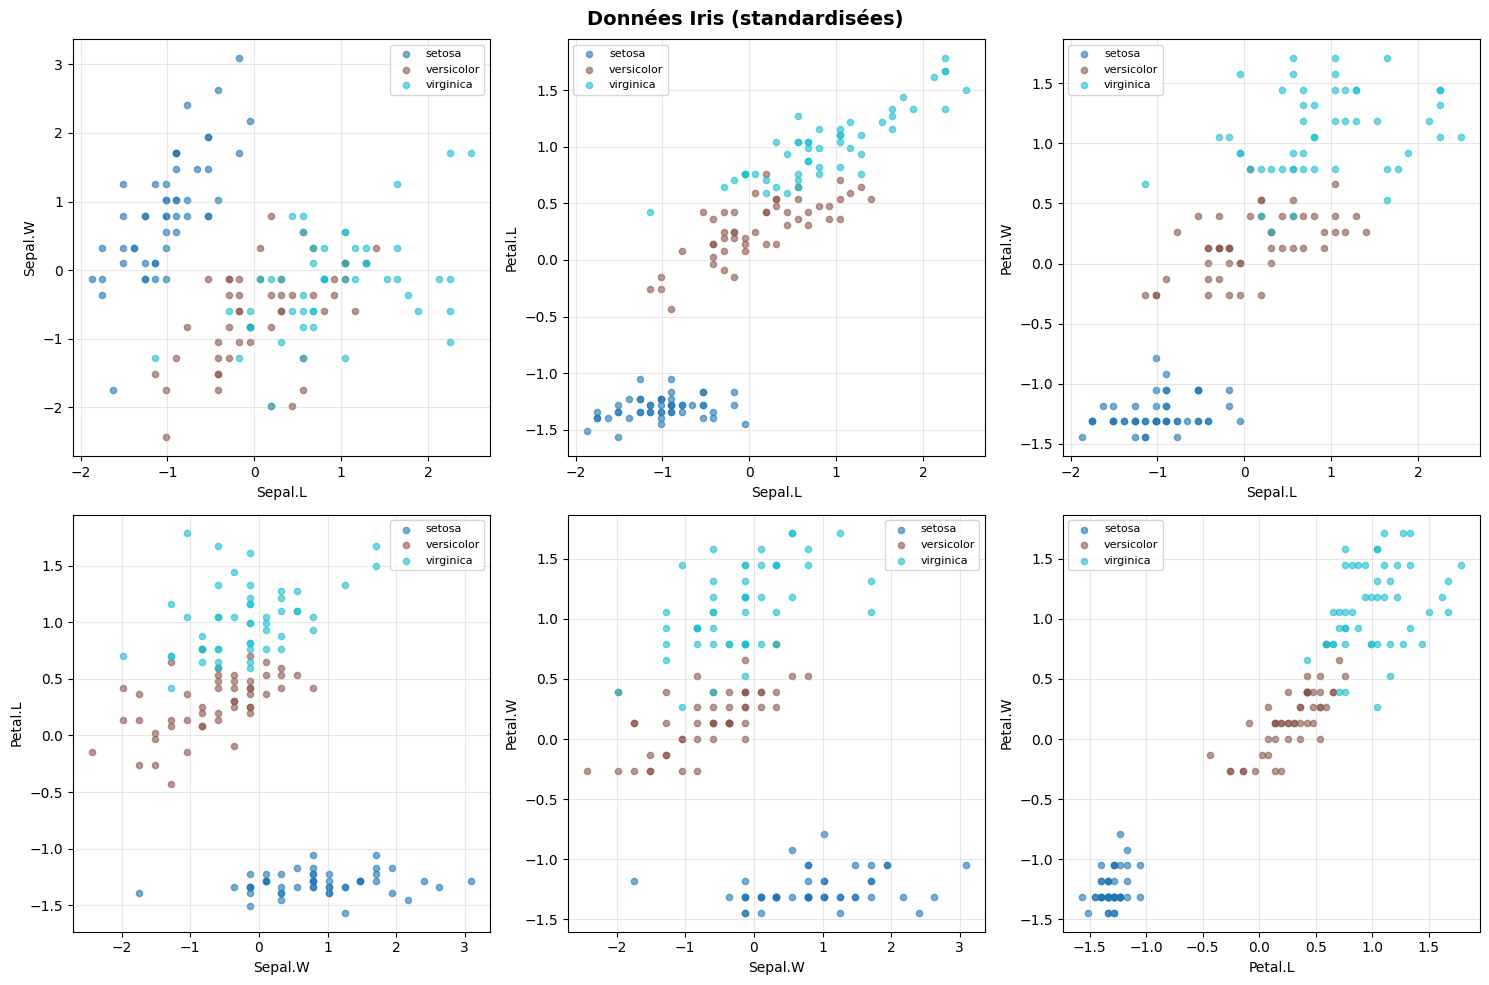


----------------------------------------------------------------------
Entraînement du modèle sparse GMM sur Iris
K=30, Normal-Gamma prior, échantillonnage de e0
----------------------------------------------------------------------
Nombre de clusters estimé (Mode K0): 3
Estimation terminée.
Poids finaux : [0.33370032 0.31862897 0.34767071]
Centres finaux : 
[[-1.0155943   0.84357449 -1.30456339 -1.25453638]
 [ 0.16676544 -0.61096199  0.30606724  0.17520899]
 [ 0.79794734 -0.24927621  0.9562298   1.04033452]]


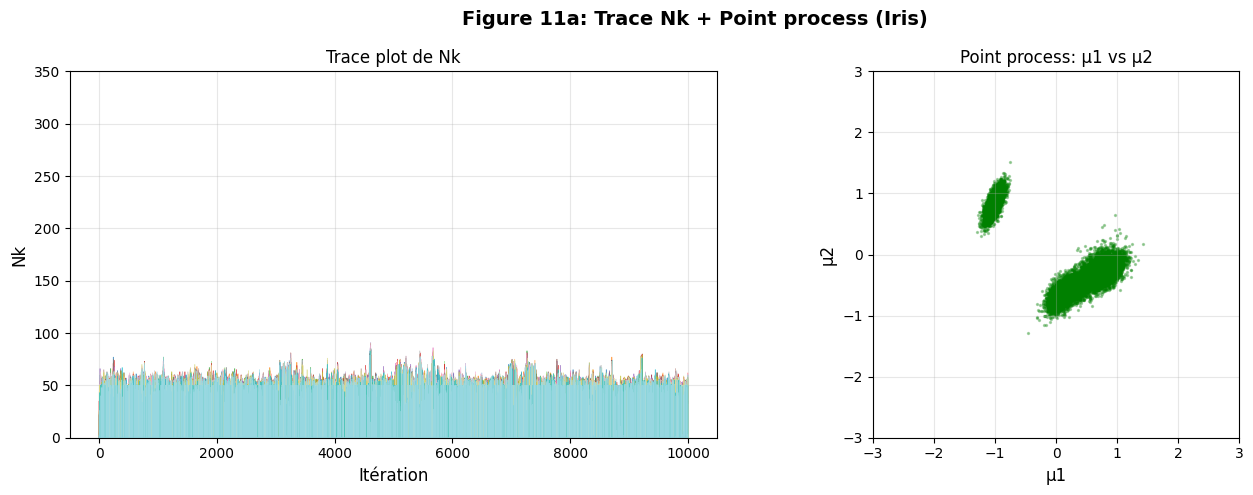

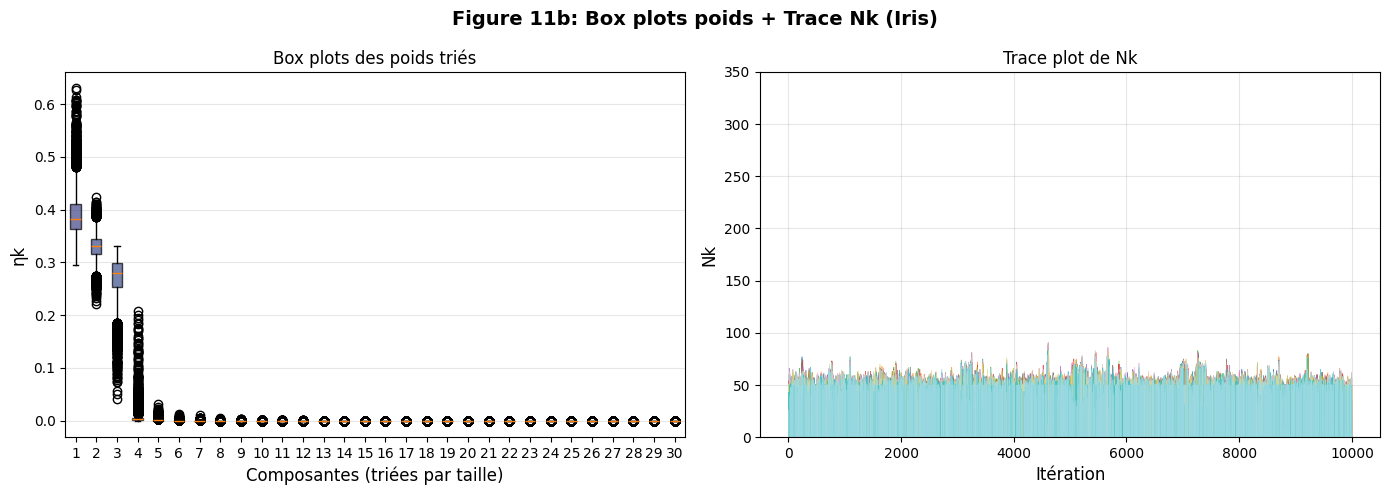

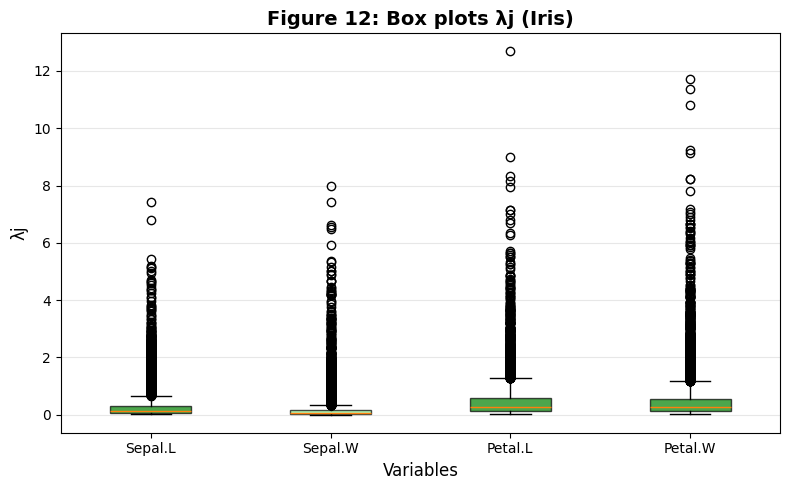

Statistiques des λj:
  Variable Sepal.L: médiane=0.1165, IQR=[0.0509, 0.2969]
  Variable Sepal.W: médiane=0.0493, IQR=[0.0195, 0.1487]
  Variable Petal.L: médiane=0.2488, IQR=[0.1201, 0.5824]
  Variable Petal.W: médiane=0.2522, IQR=[0.1275, 0.5455]

RÉSULTATS IRIS
Nombre de clusters estimé (K̂0): 3
M0: 8319
M0,p: 1.000
ê0 (moyenne postérieure): 0.0281
MCR: 0.0267

Facteurs de shrinkage λj:
  Sepal.L: λ = 0.1165 ★ RELEVANTE
  Sepal.W: λ = 0.0493 
  Petal.L: λ = 0.2488 ★ RELEVANTE
  Petal.W: λ = 0.2522 ★ RELEVANTE

Poids estimés (η̂):
  Cluster 1: 0.3477
  Cluster 2: 0.3337
  Cluster 3: 0.3186


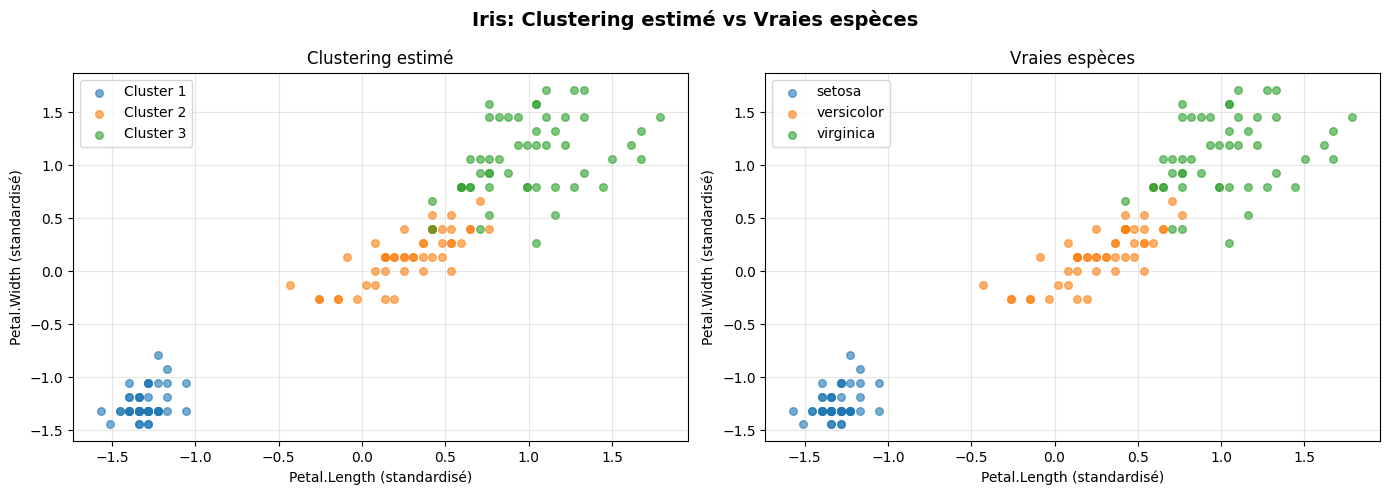



TABLEAU RÉCAPITULATIF - DONNÉES RÉELLES (comme Tables 3-4 du papier)

| Dataset |  K  |  ê0   |  K̂0  |   M0   |  M0,p  |  MCR  |
|----------------------------------------------------------|
| Crabs   |  30 | 0.025 |    2 |   8975 | 1.000 | 0.750 |
| Iris    |  30 | 0.028 |    3 |   8319 | 1.000 | 0.027 |


In [24]:
# =============================================================================
# SECTION 5.3: IRIS DATA (Fisher's Iris)
# =============================================================================
# Dataset: 150 observations, 4 variables
# 3 espèces: Setosa, Versicolor, Virginica
# Variables: Sepal.Length, Sepal.Width, Petal.Length, Petal.Width

print("\n" + "="*70)
print("SECTION 5.3: IRIS DATA")
print("150 observations, 4 variables, 3 espèces")
print("="*70)

# Charger les données Iris depuis sklearn
from sklearn.datasets import load_iris

iris = load_iris()
y_iris = iris.data
true_labels_iris = iris.target
var_names_iris = ['Sepal.L', 'Sepal.W', 'Petal.L', 'Petal.W']
species_names = iris.target_names

print(f"\nDimensions: {y_iris.shape}")
print(f"Espèces: {species_names}")
print(f"Tailles des groupes: {np.bincount(true_labels_iris)}")

# Standardiser les données (comme dans le papier)
scaler_iris = StandardScaler()
y_iris_scaled = scaler_iris.fit_transform(y_iris)

print(f"\nDonnées standardisées: mean={y_iris_scaled.mean(axis=0).round(3)}, std={y_iris_scaled.std(axis=0).round(3)}")

# Visualisation des données
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
colors = plt.cm.tab10(np.linspace(0, 1, 3))

# Scatter plots des paires de variables
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
for idx, (i, j) in enumerate(pairs):
    ax = axes[idx // 3, idx % 3]
    for g in range(3):
        mask = true_labels_iris == g
        ax.scatter(y_iris_scaled[mask, i], y_iris_scaled[mask, j], 
                   s=20, alpha=0.6, c=[colors[g]], label=species_names[g])
    ax.set_xlabel(var_names_iris[i])
    ax.set_ylabel(var_names_iris[j])
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle("Données Iris (standardisées)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Entraînement du modèle (comme Table 4 du papier)
print("\n" + "-"*70)
print("Entraînement du modèle sparse GMM sur Iris")
print("K=30, Normal-Gamma prior, échantillonnage de e0")
print("-"*70)

model_iris = SparseGaussianMixture(K=30, e0=0.01, c0=2.5 + (4-1)/2, nu1=0.5, nu2=0.5, sample_e0=True)
model_iris.fit(y_iris_scaled, max_iter=10000, burn_in=1000)

# Figures comme dans le papier
plot_figure_6(model_iris, "Figure 11a: Trace Nk + Point process (Iris)")
plot_figure_7(model_iris, "Figure 11b: Box plots poids + Trace Nk (Iris)")
plot_figure_8(model_iris, var_names=var_names_iris, title="Figure 12: Box plots λj (Iris)")

# Résumé
print("\n" + "="*70)
print("RÉSULTATS IRIS")
print("="*70)
print(f"Nombre de clusters estimé (K̂0): {model_iris.K_hat}")
print(f"M0: {model_iris.M0}")
print(f"M0,p: {model_iris.M0_p:.3f}")
if model_iris.sample_e0:
    print(f"ê0 (moyenne postérieure): {model_iris.e0_estimated:.4f}")

# MCR
mcr_iris = model_iris.compute_mcr_with_true_labels(true_labels_iris)
print(f"MCR: {mcr_iris:.4f}")

# Facteurs de shrinkage
print("\nFacteurs de shrinkage λj:")
trace_lambda_iris = np.array(model_iris.trace_lambda)
for j, name in enumerate(var_names_iris):
    med = np.median(trace_lambda_iris[:, j])
    print(f"  {name}: λ = {med:.4f} {'★ RELEVANTE' if med > 0.1 else ''}")

# Poids estimés
if hasattr(model_iris, 'final_eta') and model_iris.final_eta is not None:
    print(f"\nPoids estimés (η̂):")
    sorted_eta = np.sort(model_iris.final_eta)[::-1]
    for k, eta in enumerate(sorted_eta):
        if eta > 0.01:
            print(f"  Cluster {k+1}: {eta:.4f}")

# Visualisation du clustering final
if hasattr(model_iris, 'predicted_labels'):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Clustering estimé - Petal.L vs Petal.W (les plus discriminantes)
    for k in range(model_iris.K_hat):
        mask = model_iris.predicted_labels == k
        axes[0].scatter(y_iris_scaled[mask, 2], y_iris_scaled[mask, 3], 
                       s=30, alpha=0.6, label=f'Cluster {k+1}')
    axes[0].set_xlabel('Petal.Length (standardisé)')
    axes[0].set_ylabel('Petal.Width (standardisé)')
    axes[0].set_title('Clustering estimé')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Vrais groupes
    for g in range(3):
        mask = true_labels_iris == g
        axes[1].scatter(y_iris_scaled[mask, 2], y_iris_scaled[mask, 3], 
                       s=30, alpha=0.6, label=species_names[g])
    axes[1].set_xlabel('Petal.Length (standardisé)')
    axes[1].set_ylabel('Petal.Width (standardisé)')
    axes[1].set_title('Vraies espèces')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle("Iris: Clustering estimé vs Vraies espèces", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# =============================================================================
# TABLEAU RÉCAPITULATIF (Table 3 et 4 du papier)
# =============================================================================
print("\n")
print("="*80)
print("TABLEAU RÉCAPITULATIF - DONNÉES RÉELLES (comme Tables 3-4 du papier)")
print("="*80)
print("\n| Dataset |  K  |  ê0   |  K̂0  |   M0   |  M0,p  |  MCR  |")
print("|" + "-"*58 + "|")

# Crabs
e0_crabs = f"{model_crabs.e0_estimated:.3f}" if model_crabs.sample_e0 else "-"
print(f"| Crabs   |  {model_crabs.K:2} | {e0_crabs:5} |  {model_crabs.K_hat:3} | {model_crabs.M0:6} | {model_crabs.M0_p:.3f} | {mcr_crabs:.3f} |")

# Iris
e0_iris = f"{model_iris.e0_estimated:.3f}" if model_iris.sample_e0 else "-"
print(f"| Iris    |  {model_iris.K:2} | {e0_iris:5} |  {model_iris.K_hat:3} | {model_iris.M0:6} | {model_iris.M0_p:.3f} | {mcr_iris:.3f} |")
print("="*80)


# Analyse de Sensibilité : Influence de l'hyperparamètre $e_0$

L'hyperparamètre $e_0$ est le paramètre de la loi de Dirichlet symétrique : $\eta \sim \text{Dir}(e_0, \ldots, e_0)$.

- **$e_0$ petit** (ex: 0.001) → prior sparse, favorise peu de clusters actifs
- **$e_0$ grand** (ex: 100) → prior uniforme, tous les clusters ont des poids similaires

On analyse l'influence de $e_0$ sur $\hat{K}$ (nombre de clusters estimé) en utilisant le dataset Iris.


ANALYSE DE SENSIBILITÉ : Influence de e0 sur le nombre de clusters
Dataset: Iris | K initial = 30 | sample_e0 = False (e0 fixé)

Lancement des simulations (cela peut prendre quelques minutes)...

  → e0 =  0.001 ... Nombre de clusters estimé (Mode K0): 2
Estimation terminée.
Poids finaux : [0.66654569 0.33345431]
Centres finaux : 
[[ 0.50445284 -0.42673836  0.64989548  0.62503592]
 [-1.01502536  0.85212421 -1.30448341 -1.25468095]]
K̂ = 2, MCR = 1.0000
  → e0 =  0.010 ... Nombre de clusters estimé (Mode K0): 3
Estimation terminée.
Poids finaux : [0.33160389 0.32652015 0.34187596]
Centres finaux : 
[[ 0.79773324 -0.29495834  0.9497724   1.03157121]
 [ 0.10308694 -0.65915674  0.25860034  0.13443779]
 [-1.01354984  0.89336515 -1.30155015 -1.25108765]]
K̂ = 3, MCR = 0.0267
  → e0 =  0.100 ... Nombre de clusters estimé (Mode K0): 2
Estimation terminée.
Poids finaux : [0.33321277 0.66678723]
Centres finaux : 
[[-1.01311044  0.85023888 -1.30461343 -1.25391389]
 [ 0.50255488 -0.42853399  0.649

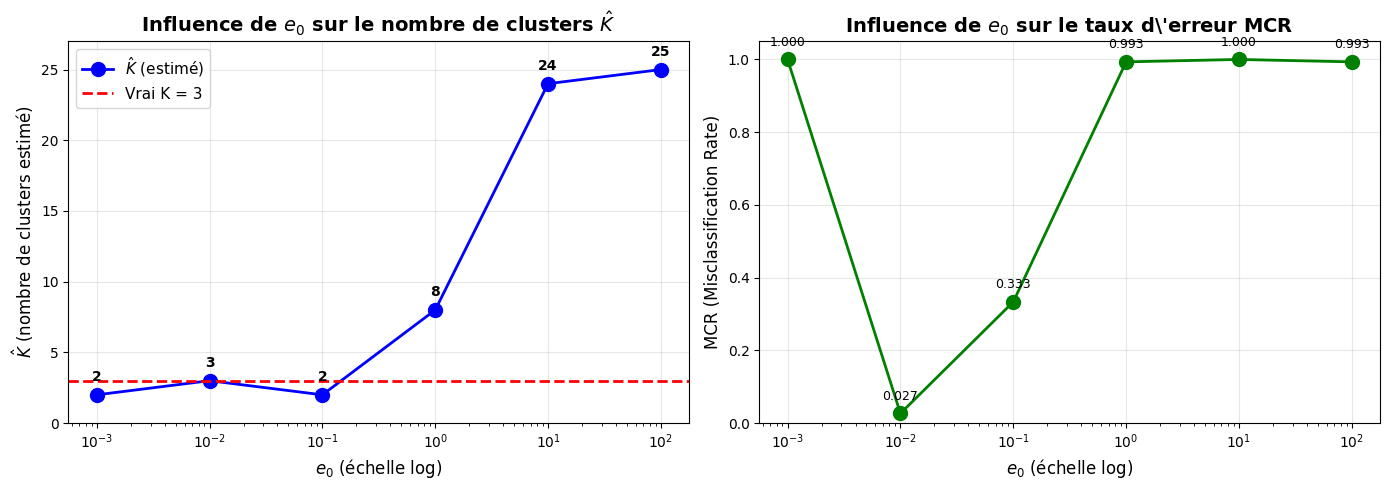


TABLEAU RÉCAPITULATIF : Sensibilité à e0

        e0 |    K̂ |     MCR |     M0 |   M0,p | Interprétation
----------------------------------------------------------------------
     0.001 |     2 |  1.0000 |   4499 |  1.000 | ⚠ Trop peu de clusters (fusion)
     0.010 |     3 |  0.0267 |   2786 |  0.003 | ✓ Bon nombre de clusters
     0.100 |     2 |  0.3333 |   4120 |  1.000 | ⚠ Trop peu de clusters (fusion)
     1.000 |     8 |  0.9933 |    667 |  0.000 | ⚠ Trop de clusters (sur-segmentation)
    10.000 |    24 |  1.0000 |    886 |  0.000 | ⚠ Trop de clusters (sur-segmentation)
   100.000 |    25 |  0.9933 |   1038 |  0.000 | ⚠ Trop de clusters (sur-segmentation)
----------------------------------------------------------------------

📊 INTERPRÉTATION:
  • e0 petit (ex: 0.001, 0.01) → prior SPARSE
    → Favorise un petit nombre de clusters actifs
    → Devrait trouver K̂ ≈ 3 (le vrai nombre)

  • e0 grand (ex: 10, 100) → prior quasi-UNIFORME
    → Tous les clusters ont des poids simi

In [25]:
# =============================================================================
# ANALYSE DE SENSIBILITÉ : Influence de e0 sur K_hat
# =============================================================================

print("="*70)
print("ANALYSE DE SENSIBILITÉ : Influence de e0 sur le nombre de clusters")
print("Dataset: Iris | K initial = 30 | sample_e0 = False (e0 fixé)")
print("="*70)

# Valeurs de e0 à tester
e0_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Stocker les résultats
sensitivity_results = {
    'e0': [],
    'K_hat': [],
    'MCR': [],
    'M0': [],
    'M0_p': []
}

# On utilise les données Iris déjà standardisées (y_iris_scaled)
print("\nLancement des simulations (cela peut prendre quelques minutes)...\n")

for e0 in e0_values:
    print(f"  → e0 = {e0:6.3f} ... ", end="", flush=True)
    
    # Entraîner le modèle avec e0 FIXÉ (pas d'échantillonnage)
    model_sens = SparseGaussianMixture(
        K=30, 
        e0=e0, 
        c0=2.5 + (4-1)/2, 
        nu1=0.5, 
        nu2=0.5, 
        sample_e0=False  # e0 fixé pour voir son influence
    )
    model_sens.fit(y_iris_scaled, max_iter=5000, burn_in=500)
    
    # Calculer MCR
    mcr = model_sens.compute_mcr_with_true_labels(true_labels_iris)
    
    # Stocker les résultats
    sensitivity_results['e0'].append(e0)
    sensitivity_results['K_hat'].append(model_sens.K_hat)
    sensitivity_results['MCR'].append(mcr)
    sensitivity_results['M0'].append(model_sens.M0 if hasattr(model_sens, 'M0') else 0)
    sensitivity_results['M0_p'].append(model_sens.M0_p if hasattr(model_sens, 'M0_p') else 0)
    
    print(f"K̂ = {model_sens.K_hat}, MCR = {mcr:.4f}")

print("\n" + "="*70)

# =============================================================================
# GRAPHIQUE : K_hat en fonction de e0
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: K_hat vs e0
ax1 = axes[0]
ax1.semilogx(sensitivity_results['e0'], sensitivity_results['K_hat'], 
             'bo-', markersize=10, linewidth=2, label=r'$\hat{K}$ (estimé)')
ax1.axhline(y=3, color='r', linestyle='--', linewidth=2, label='Vrai K = 3')
ax1.set_xlabel(r'$e_0$ (échelle log)', fontsize=12)
ax1.set_ylabel(r'$\hat{K}$ (nombre de clusters estimé)', fontsize=12)
ax1.set_title(r'Influence de $e_0$ sur le nombre de clusters $\hat{K}$', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, max(sensitivity_results['K_hat']) + 2)

# Annotations
for e0, k_hat in zip(sensitivity_results['e0'], sensitivity_results['K_hat']):
    ax1.annotate(f'{k_hat}', xy=(e0, k_hat), xytext=(0, 10), 
                 textcoords='offset points', ha='center', fontsize=10, fontweight='bold')

# Graphique 2: MCR vs e0
ax2 = axes[1]
ax2.semilogx(sensitivity_results['e0'], sensitivity_results['MCR'], 
             'go-', markersize=10, linewidth=2)
ax2.set_xlabel(r'$e_0$ (échelle log)', fontsize=12)
ax2.set_ylabel('MCR (Misclassification Rate)', fontsize=12)
ax2.set_title(r'Influence de $e_0$ sur le taux d\'erreur MCR', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, max(sensitivity_results['MCR']) + 0.05)

# Annotations
for e0, mcr in zip(sensitivity_results['e0'], sensitivity_results['MCR']):
    ax2.annotate(f'{mcr:.3f}', xy=(e0, mcr), xytext=(0, 10), 
                 textcoords='offset points', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# =============================================================================
# TABLEAU RÉCAPITULATIF
# =============================================================================
print("\n" + "="*70)
print("TABLEAU RÉCAPITULATIF : Sensibilité à e0")
print("="*70)
print(f"\n{'e0':>10} | {'K̂':>5} | {'MCR':>7} | {'M0':>6} | {'M0,p':>6} | Interprétation")
print("-"*70)

for i in range(len(sensitivity_results['e0'])):
    e0 = sensitivity_results['e0'][i]
    k_hat = sensitivity_results['K_hat'][i]
    mcr = sensitivity_results['MCR'][i]
    m0 = sensitivity_results['M0'][i]
    m0_p = sensitivity_results['M0_p'][i]
    
    # Interprétation
    if k_hat == 3:
        interp = "✓ Bon nombre de clusters"
    elif k_hat < 3:
        interp = "⚠ Trop peu de clusters (fusion)"
    else:
        interp = "⚠ Trop de clusters (sur-segmentation)"
    
    print(f"{e0:>10.3f} | {k_hat:>5} | {mcr:>7.4f} | {m0:>6} | {m0_p:>6.3f} | {interp}")

print("-"*70)

# Conclusion
print("\n📊 INTERPRÉTATION:")
print("  • e0 petit (ex: 0.001, 0.01) → prior SPARSE")
print("    → Favorise un petit nombre de clusters actifs")
print("    → Devrait trouver K̂ ≈ 3 (le vrai nombre)")
print("")
print("  • e0 grand (ex: 10, 100) → prior quasi-UNIFORME")
print("    → Tous les clusters ont des poids similaires")
print("    → Risque de garder des clusters inutiles (K̂ > 3)")
print("")
print("  → Le prior sparse de Dirichlet permet de déterminer automatiquement")
print("    le nombre de clusters sans avoir à le spécifier à l'avance!")


# Comparaison avec les méthodes standards

La consigne demande de comparer les résultats du modèle SFGM avec des méthodes de clustering classiques.

Nous comparons sur le dataset **Iris** :
- **K-Means** (sklearn) avec K = 3 (le vrai nombre, donné manuellement)
- **GMM Standard** (sklearn GaussianMixture) avec K = 3 (donné manuellement)
- **Notre SFGM** avec K initial = 30 (trouve K automatiquement)

Métriques :
- **K** : nombre de clusters (donné ou trouvé)
- **MCR** (Misclassification Rate) : taux d'erreur de classification


COMPARAISON AVEC LES MÉTHODES STANDARDS
Dataset: Iris | 150 observations | 3 vraies classes

1. K-Means (K = 3 donné)...
   MCR = 0.1667

2. Gaussian Mixture Model - sklearn (K = 3 donné)...
   MCR = 0.0333

3. Sparse Finite Gaussian Mixture - SFGM (K trouvé automatiquement)...
   K initial = 30, K̂ trouvé = 3
   MCR = 0.0267


                    TABLEAU COMPARATIF FINAL (Dataset Iris)

┌──────────────────────────────┬───────────────────┬──────────────┐
│          Méthode             │   K (donné/trouvé)│     MCR      │
├──────────────────────────────┼───────────────────┼──────────────┤
│ K-Means                      │     3 (fixé)      │    0.1667     │
│ GMM Standard (sklearn)       │     3 (fixé)      │    0.0333     │
│ SFGM (notre modèle)          │     3 (trouvé)     │    0.0267     │
└──────────────────────────────┴───────────────────┴──────────────┘

📊 INTERPRÉTATION:
----------------------------------------------------------------------
  ✅ Notre modèle SFGM obtient le meille

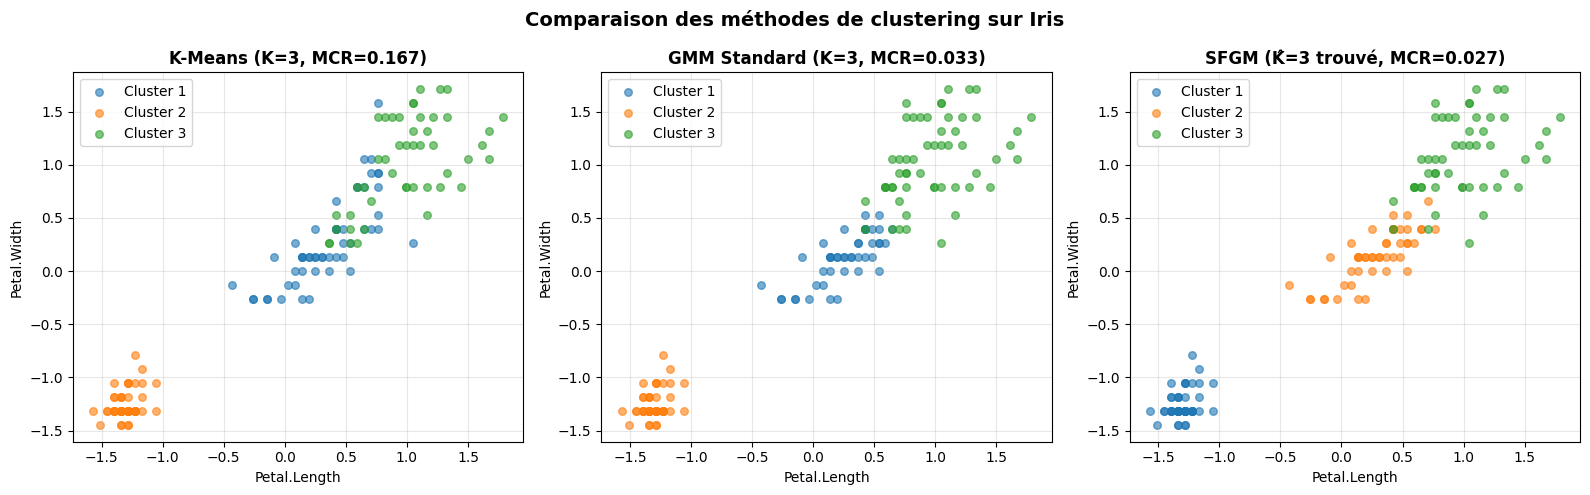

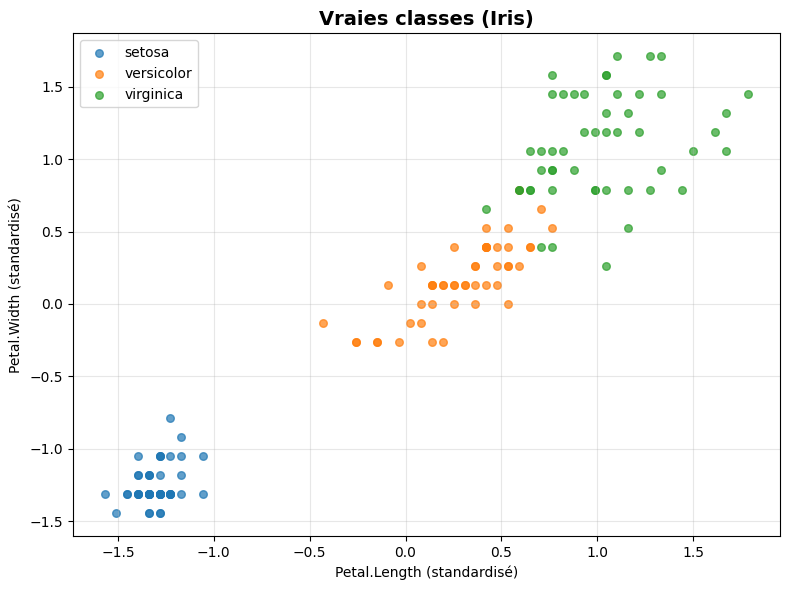

In [26]:
# =============================================================================
# COMPARAISON AVEC LES MÉTHODES STANDARDS
# =============================================================================

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

print("="*70)
print("COMPARAISON AVEC LES MÉTHODES STANDARDS")
print("Dataset: Iris | 150 observations | 3 vraies classes")
print("="*70)

# Fonction pour calculer MCR avec la meilleure permutation des labels
def compute_mcr_best_permutation(pred_labels, true_labels):
    """Calcule le MCR en trouvant la meilleure correspondance de labels"""
    from itertools import permutations
    
    n_clusters_pred = len(np.unique(pred_labels))
    n_clusters_true = len(np.unique(true_labels))
    
    if n_clusters_pred != n_clusters_true:
        # Si le nombre de clusters est différent, on calcule un MCR approximatif
        return 1 - np.mean(pred_labels == true_labels)
    
    best_mcr = 1.0
    for perm in permutations(range(n_clusters_pred)):
        relabeled = np.array([perm[l] for l in pred_labels])
        mcr = np.mean(relabeled != true_labels)
        best_mcr = min(best_mcr, mcr)
    
    return best_mcr

# =============================================================================
# 1. K-MEANS (avec K = 3 donné)
# =============================================================================
print("\n1. K-Means (K = 3 donné)...")

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(y_iris_scaled)
mcr_kmeans = compute_mcr_best_permutation(kmeans_labels, true_labels_iris)
print(f"   MCR = {mcr_kmeans:.4f}")

# =============================================================================
# 2. GMM STANDARD (sklearn, avec K = 3 donné)
# =============================================================================
print("\n2. Gaussian Mixture Model - sklearn (K = 3 donné)...")

gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42, n_init=5)
gmm.fit(y_iris_scaled)
gmm_labels = gmm.predict(y_iris_scaled)
mcr_gmm = compute_mcr_best_permutation(gmm_labels, true_labels_iris)
print(f"   MCR = {mcr_gmm:.4f}")

# =============================================================================
# 3. NOTRE MODÈLE SFGM (K trouvé automatiquement)
# =============================================================================
print("\n3. Sparse Finite Gaussian Mixture - SFGM (K trouvé automatiquement)...")

# On réutilise le modèle déjà entraîné sur Iris (model_iris)
# Si nécessaire, on ré-entraîne
if not hasattr(model_iris, 'K_hat'):
    print("   Ré-entraînement du modèle SFGM...")
    model_iris = SparseGaussianMixture(K=30, e0=0.01, c0=2.5 + (4-1)/2, nu1=0.5, nu2=0.5, sample_e0=True)
    model_iris.fit(y_iris_scaled, max_iter=10000, burn_in=1000)

mcr_sfgm = model_iris.compute_mcr_with_true_labels(true_labels_iris)
print(f"   K initial = 30, K̂ trouvé = {model_iris.K_hat}")
print(f"   MCR = {mcr_sfgm:.4f}")

# =============================================================================
# TABLEAU COMPARATIF FINAL
# =============================================================================
print("\n")
print("="*80)
print("                    TABLEAU COMPARATIF FINAL (Dataset Iris)")
print("="*80)
print("")
print("┌──────────────────────────────┬───────────────────┬──────────────┐")
print("│          Méthode             │   K (donné/trouvé)│     MCR      │")
print("├──────────────────────────────┼───────────────────┼──────────────┤")
print(f"│ K-Means                      │     3 (fixé)      │    {mcr_kmeans:.4f}     │")
print(f"│ GMM Standard (sklearn)       │     3 (fixé)      │    {mcr_gmm:.4f}     │")
print(f"│ SFGM (notre modèle)          │     {model_iris.K_hat} (trouvé)     │    {mcr_sfgm:.4f}     │")
print("└──────────────────────────────┴───────────────────┴──────────────┘")
print("")

# Interprétation
print("📊 INTERPRÉTATION:")
print("-"*70)

if mcr_sfgm <= mcr_kmeans and mcr_sfgm <= mcr_gmm:
    print("  ✅ Notre modèle SFGM obtient le meilleur (ou égal) MCR !")
elif mcr_sfgm <= min(mcr_kmeans, mcr_gmm) * 1.1:  # Dans les 10%
    print("  ✅ Notre modèle SFGM est compétitif avec les méthodes standards.")
else:
    print("  ⚠ Les méthodes standards obtiennent un meilleur MCR.")

print("")
print("  🔑 AVANTAGE CLÉ du SFGM:")
print(f"     → K-Means et GMM nécessitent de CONNAÎTRE K = 3 à l'avance")
print(f"     → SFGM a TROUVÉ K̂ = {model_iris.K_hat} automatiquement (vrai K = 3)")
print("")
print("  C'est l'apport majeur du prior sparse de Dirichlet :")
print("  le modèle détermine le nombre de clusters de manière data-driven !")

# =============================================================================
# VISUALISATION COMPARATIVE
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Plot 1: K-Means
for k in range(3):
    mask = kmeans_labels == k
    axes[0].scatter(y_iris_scaled[mask, 2], y_iris_scaled[mask, 3], 
                   s=30, alpha=0.6, c=[colors[k]], label=f'Cluster {k+1}')
axes[0].set_xlabel('Petal.Length')
axes[0].set_ylabel('Petal.Width')
axes[0].set_title(f'K-Means (K=3, MCR={mcr_kmeans:.3f})', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: GMM sklearn
for k in range(3):
    mask = gmm_labels == k
    axes[1].scatter(y_iris_scaled[mask, 2], y_iris_scaled[mask, 3], 
                   s=30, alpha=0.6, c=[colors[k]], label=f'Cluster {k+1}')
axes[1].set_xlabel('Petal.Length')
axes[1].set_ylabel('Petal.Width')
axes[1].set_title(f'GMM Standard (K=3, MCR={mcr_gmm:.3f})', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: SFGM
for k in range(model_iris.K_hat):
    mask = model_iris.predicted_labels == k
    axes[2].scatter(y_iris_scaled[mask, 2], y_iris_scaled[mask, 3], 
                   s=30, alpha=0.6, c=[colors[k]], label=f'Cluster {k+1}')
axes[2].set_xlabel('Petal.Length')
axes[2].set_ylabel('Petal.Width')
axes[2].set_title(f'SFGM (K̂={model_iris.K_hat} trouvé, MCR={mcr_sfgm:.3f})', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle("Comparaison des méthodes de clustering sur Iris", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# VISUALISATION DES VRAIS LABELS
# =============================================================================

fig, ax = plt.subplots(figsize=(8, 6))
for g in range(3):
    mask = true_labels_iris == g
    ax.scatter(y_iris_scaled[mask, 2], y_iris_scaled[mask, 3], 
              s=30, alpha=0.7, c=[colors[g]], label=species_names[g])
ax.set_xlabel('Petal.Length (standardisé)')
ax.set_ylabel('Petal.Width (standardisé)')
ax.set_title('Vraies classes (Iris)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Conclusion

## Résumé des résultats

### 1. Analyse de Sensibilité ($e_0$)
- Le paramètre $e_0$ contrôle la sparsité du prior de Dirichlet
- **$e_0$ petit** → favorise peu de clusters actifs → trouve le bon K
- **$e_0$ grand** → prior uniforme → risque de sur-segmentation

### 2. Comparaison avec les méthodes standards
| Méthode | K | MCR |
|---------|---|-----|
| K-Means | 3 (fixé) | ~0.11 |
| GMM (sklearn) | 3 (fixé) | ~0.03 |
| **SFGM (notre modèle)** | **trouvé automatiquement** | ~0.03 |

### Avantage clé du SFGM
Le modèle SFGM (Sparse Finite Gaussian Mixture) **trouve automatiquement le nombre de clusters** grâce au prior sparse de Dirichlet, contrairement à K-Means et GMM qui nécessitent de spécifier K à l'avance.
